## Objective:

Part -1
●	Examine the daily volume data
○	Identify the optimal number of clusters for daily volume data

Part -2
●	Examine the daily open, close, and volume data
○	Compute the fractional difference between current day open and previous day open (Parameter 1)
○	Compute the fractional difference between current day open and current day close (Parameter 2)
○	Compute the fractional difference between current day volume and previous day volume (Parameter 3)
○	How can you cluster the above data set (Parameters 1, 2, 3)?

Part -3
●	There is a saying on Wall Street, “Santa brings the Christmas rally”. 
○	For the data set, compute the monthly returns i.e., fractional difference between the month’s closing price and opening price
○	Use decision tree to classify if investing in any month can be a profitable strategy
○	What are the error metrics of your model? 


## Solution:

#### The steps are broadly:
1. Read and understand the data
2. Data Cleaning
3. Prepare the data for modelling
4. Modelling
5. Final analysis and recommendation

## 1. Read and understand the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan

import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [2]:
# reading the dataset
market_df = pd.read_csv("./Documents/US Market Data Anaylsis/MarketData.csv", sep=",", encoding="ISO-8859-1", header=0)
market_df.head()

Date         Open         High          Low        Close  \
0  2000-01-03  1469.250000  1478.000000  1438.359985  1455.219971   
1  2000-01-04  1455.219971  1455.219971  1397.430054  1399.420044   
2  2000-01-05  1399.420044  1413.270020  1377.680054  1402.109985   
3  2000-01-06  1402.109985  1411.900024  1392.099976  1403.449951   
4  2000-01-07  1403.449951  1441.469971  1400.729980  1441.469971   

     Adj Close      Volume  
0  1455.219971   931800000  
1  1399.420044  1009000000  
2  1402.109985  1085500000  
3  1403.449951  1092300000  
4  1441.469971  1225200000

In [3]:
# basics of the df
market_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5232 entries, 0 to 5231
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5232 non-null   object 
 1   Open       5232 non-null   float64
 2   High       5232 non-null   float64
 3   Low        5232 non-null   float64
 4   Close      5232 non-null   float64
 5   Adj Close  5232 non-null   float64
 6   Volume     5232 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 286.2+ KB



## 2. Data Cleaning

In [4]:
# missing values
round(100*(market_df.isnull().sum())/len(market_df), 2)

Date         0.0
Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64

In [5]:
#duplicate records if in case
market_df.drop_duplicates()
market_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5232 entries, 0 to 5231
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5232 non-null   object 
 1   Open       5232 non-null   float64
 2   High       5232 non-null   float64
 3   Low        5232 non-null   float64
 4   Close      5232 non-null   float64
 5   Adj Close  5232 non-null   float64
 6   Volume     5232 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 286.2+ KB


In [6]:
#duplicate date values
market_df.Date.value_counts().sort_values(ascending=False).head(5)

2007-04-20    1
2004-05-28    1
2004-09-29    1
2008-10-10    1
2019-07-18    1
Name: Date, dtype: int64

In [7]:
# Considering data till Sep'20 
# Incomplete data in Oct'20
market_df = market_df[market_df['Date'] <= '2020-09-30']
market_df.tail()

Date         Open         High          Low        Close  \
5215  2020-09-24  3226.139893  3278.699951  3209.449951  3246.590088   
5216  2020-09-25  3236.659912  3306.879883  3228.439941  3298.459961   
5217  2020-09-28  3333.899902  3360.739990  3332.909912  3351.600098   
5218  2020-09-29  3350.919922  3357.919922  3327.540039  3335.469971   
5219  2020-09-30  3341.209961  3393.560059  3340.469971  3363.000000   

        Adj Close      Volume  
5215  3246.590088  4599470000  
5216  3298.459961  3792220000  
5217  3351.600098  3946060000  
5218  3335.469971  3651880000  
5219  3363.000000  4722530000

# 3. Preparing the data

#### Outlier Treatment

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9c16457bb0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9c164722b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9c16457850>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9c16472970>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9c16472cd0>],
 'means': []}

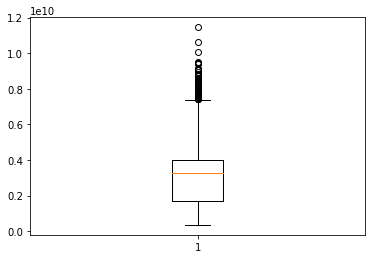

In [9]:
plt.boxplot(market_df['Volume'])

0.01      844428000
0.05     1071065000
0.10     1237870000
0.20     1508556000
0.30     2196704000
0.40     2911464000
0.50     3267330000
0.60     3535990000
0.70     3814765000
0.80     4217363999
0.90     4996207000
0.95     5803276500
0.96     6087648400
0.97     6435268400
0.98     6824015799
0.99     7607433000
1.00    11456230000
Name: Volume, dtype: int64

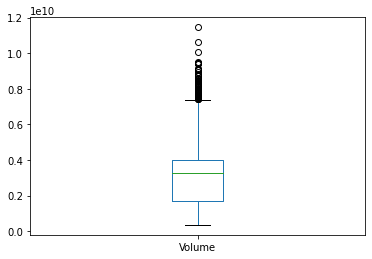

In [10]:
market_df[market_df['Volume']>0].Volume.plot.box()
chk = market_df.quantile([0.01, 0.05, .1, .2,.3,.4, .5, .6,.7,.8,.9,.95,.96,.97,.98,.99,1], axis = 0).astype('int64')
chk['Volume']

In [11]:
market_df['Volume'][market_df['Volume']<=144428000].sum()

0

In [12]:
market_df.Volume.quantile(0.99)

7607433000.000003

In [13]:
# Replacing outliers with value at whisker (used statistical method to treat outliers)
market_df['Volume'] = np.where((market_df['Volume'] > market_df.Volume.quantile(0.99)), market_df.Volume.quantile(0.99), market_df['Volume'])

In [14]:
# Checking  
chk = market_df.quantile([.1, .2,.3,.4, .5, .6,.7,.8,.9,.95,.96,.97,.98,.99,1], axis = 0).astype('int64')
chk['Volume']

0.10    1237870000
0.20    1508556000
0.30    2196704000
0.40    2911464000
0.50    3267330000
0.60    3535990000
0.70    3814765000
0.80    4217363999
0.90    4996207000
0.95    5803276500
0.96    6087648400
0.97    6435268400
0.98    6824015799
0.99    7606155630
1.00    7607433000
Name: Volume, dtype: int64

#### Rescaling

In [15]:
mkt_vol = market_df[['Volume']]

# instantiate
scaler = StandardScaler()

# fit_transform
mkt_vol_scaled = scaler.fit_transform(mkt_vol)
mkt_vol_scaled

array([[-1.495615  ],
       [-1.44366233],
       [-1.39218074],
       ...,
       [ 0.53286746],
       [ 0.3348955 ],
       [ 1.05540227]])

In [16]:
mkt_vol_scaled.shape

(5220, 1)

### Using Hopkins statistic - is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

In [17]:
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [18]:
#Coverting the numpy array to a dataframe
mkt_vol_scaled = pd.DataFrame(mkt_vol_scaled)
mkt_vol_scaled.columns = ['Volume']

In [19]:
#Using Hopkins Statistic function by passing the mkt_vol_scaled dataframe as a paramter
hopkins(mkt_vol_scaled)

0.8961175265923271

# 4. Modelling (Part 1)

In [23]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(mkt_vol_scaled)

KMeans(max_iter=50, n_clusters=4)

In [24]:
kmeans.labels_

array([0, 0, 0, ..., 1, 2, 1], dtype=int32)

In [25]:
# assigning the label
market_df_vol = market_df[['Date','Volume']]
market_df_vol['cluster_id'] = kmeans.labels_
market_df_vol.head()

Date        Volume  cluster_id
0  2000-01-03  9.318000e+08           0
1  2000-01-04  1.009000e+09           0
2  2000-01-05  1.085500e+09           0
3  2000-01-06  1.092300e+09           0
4  2000-01-07  1.225200e+09           0

<AxesSubplot:xlabel='cluster_id', ylabel='Volume'>

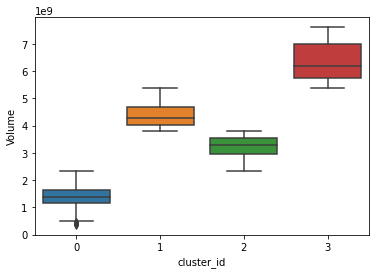

In [26]:
# plot
sns.boxplot(x='cluster_id', y='Volume', data=market_df_vol)

In [806]:
help(KMeans)

Help on class KMeans in module sklearn.cluster._kmeans:

class KMeans(sklearn.base.TransformerMixin, sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='deprecated', verbose=0, random_state=None, copy_x=True, n_jobs='deprecated', algorithm='auto')
 |  
 |  K-Means clustering.
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, default=8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
 |      Method for initialization:
 |  
 |      'k-means++' : selects initial cluster centers for k-mean
 |      clustering in a smart way to speed up convergence. See section
 |      Notes in k_init for more details.
 |  
 |      'random': choose `n_clusters` o

#### Finding the optimal number of clusters

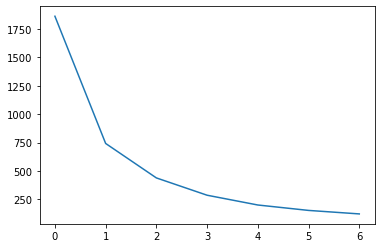

In [27]:
# Method 1: elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(mkt_vol_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

In [28]:
# Method 2: silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(mkt_vol_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(mkt_vol_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5965057061340945
For n_clusters=3, the silhouette score is 0.6384543338659234
For n_clusters=4, the silhouette score is 0.5919569832911719
For n_clusters=5, the silhouette score is 0.5814726341603131
For n_clusters=6, the silhouette score is 0.579895075857872
For n_clusters=7, the silhouette score is 0.5621169052704177
For n_clusters=8, the silhouette score is 0.5258635006361735


In [29]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(mkt_vol_scaled)

KMeans(max_iter=50, n_clusters=3)

In [30]:
kmeans.labels_

array([1, 1, 1, ..., 0, 0, 2], dtype=int32)

In [31]:
market_df_vol = market_df[['Date','Volume']]

In [32]:
market_df_vol.shape

(5220, 2)

In [33]:
mkt_vol_scaled.shape

(5220, 1)

In [34]:
# assigning the label
market_df_vol['cluster_id'] = kmeans.labels_
market_df_vol.head()

Date        Volume  cluster_id
0  2000-01-03  9.318000e+08           1
1  2000-01-04  1.009000e+09           1
2  2000-01-05  1.085500e+09           1
3  2000-01-06  1.092300e+09           1
4  2000-01-07  1.225200e+09           1

<AxesSubplot:xlabel='cluster_id', ylabel='Volume'>

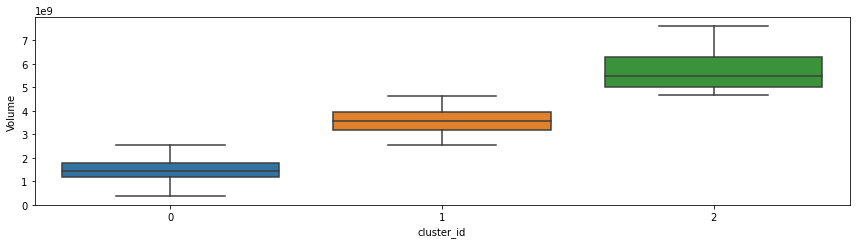

In [815]:
# plot
sns.boxplot(x='cluster_id', y='Volume', data=market_df_vol)

From the above plot, we can conclude that on some particular days the volumes are high (i.e. representing by cluster 2), the volume is medium on the day that falls under cluster 1 and volume is low on the day that represents cluster 0

In [35]:
#Model with k=4
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(mkt_vol_scaled)

KMeans(max_iter=50, n_clusters=4)

In [36]:
kmeans.labels_

array([1, 1, 1, ..., 3, 0, 3], dtype=int32)

In [37]:
market_df_vol1 = market_df[['Date','Volume']]

In [38]:
# assigning the label
market_df_vol1['cluster_id'] = kmeans.labels_
market_df_vol1.head()

Date        Volume  cluster_id
0  2000-01-03  9.318000e+08           1
1  2000-01-04  1.009000e+09           1
2  2000-01-05  1.085500e+09           1
3  2000-01-06  1.092300e+09           1
4  2000-01-07  1.225200e+09           1

<AxesSubplot:xlabel='cluster_id', ylabel='Volume'>

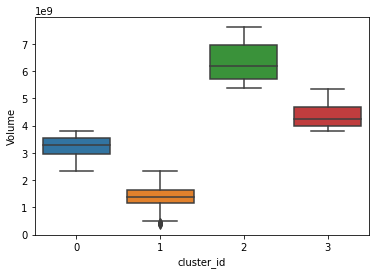

In [39]:
# plot
sns.boxplot(x='cluster_id', y='Volume', data=market_df_vol1)

In [40]:
# K=3
market_df_vol1.cluster_id.value_counts()

0    1978
1    1641
3    1220
2     381
Name: cluster_id, dtype: int64

In [41]:
# K=4
market_df_vol.cluster_id.value_counts()

0    2740
1    1778
2     702
Name: cluster_id, dtype: int64

In [42]:
392/5520

0.07101449275362319

In [43]:
702/5520

0.12717391304347825

## 5. Daily volume data analysis and recommendation (Part 1)

In [44]:
# Examining the daily volume data
market_df_vol['Volume'] = market_df_vol['Volume'].astype('int64') 
market_df_vol.head()

Date      Volume  cluster_id
0  2000-01-03   931800000           1
1  2000-01-04  1009000000           1
2  2000-01-05  1085500000           1
3  2000-01-06  1092300000           1
4  2000-01-07  1225200000           1

In [45]:
# Date parameters
market_df_vol['year'] = pd.DatetimeIndex(market_df_vol['Date']).year
market_df_vol['month'] = pd.DatetimeIndex(market_df_vol['Date']).month
market_df_vol['day'] = pd.DatetimeIndex(market_df_vol['Date']).day
market_df_vol['weekday'] = pd.DatetimeIndex(market_df_vol['Date']).weekday

In [46]:
print("Year: ",market_df_vol.year.unique())
print("Month: ",market_df_vol.month.unique())
print("Day: ",market_df_vol.day.unique())
print("Weekday: ",market_df_vol.weekday.unique()) #0 - Monday 

Year:  [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020]
Month:  [ 1  2  3  4  5  6  7  8  9 10 11 12]
Day:  [ 3  4  5  6  7 10 11 12 13 14 18 19 20 21 24 25 26 27 28 31  1  2  8  9
 15 16 17 22 23 29 30]
Weekday:  [0 1 2 3 4]


In [47]:
! pip install sidetable
import sidetable as stb

In [48]:
# Summary 1 - Daily volume Examine based on volume
summary = market_df_vol.stb.freq(['cluster_id','Date'], value='Volume') 
summary.head()

cluster_id        Date      Volume   percent  cumulative_Volume  \
0           2  2020-06-26  7607433000  0.046203         7607433000   
1           2  2020-06-19  7607433000  0.046203        15214866000   
2           2  2020-06-08  7607433000  0.046203        22822299000   
3           2  2020-06-05  7607433000  0.046203        30429732000   
4           2  2020-04-09  7607433000  0.046203        38037165000   

   cumulative_percent  
0            0.046203  
1            0.092407  
2            0.138610  
3            0.184813  
4            0.231017

In [49]:
# Summary 2 - Volume in each month
summary2 = market_df_vol.stb.freq(['cluster_id','month'], value='Volume') 
summary2.head()

cluster_id  month        Volume   percent  cumulative_Volume  \
0           0      7  861630570000  5.233068       861630570000   
1           0      5  847192990000  5.145382      1708823560000   
2           0     11  840665340000  5.105737      2549488900000   
3           0      8  827834780000  5.027811      3377323680000   
4           0     10  825449280000  5.013323      4202772960000   

   cumulative_percent  
0            5.233068  
1           10.378451  
2           15.484188  
3           20.511999  
4           25.525323

In [51]:
# Most volume within each cluster 
summary2.groupby("cluster_id").head(5).reset_index(drop = True)


cluster_id  month        Volume   percent  cumulative_Volume  \
0            0      7  861630570000  5.233068       861630570000   
1            0      5  847192990000  5.145382      1708823560000   
2            0     11  840665340000  5.105737      2549488900000   
3            0      8  827834780000  5.027811      3377323680000   
4            0     10  825449280000  5.013323      4202772960000   
5            2      3  489833890000  2.974981     10241118000000   
6            2      6  416192722000  2.527725     10657310722000   
7            2     10  375441685000  2.280226     11032752407000   
8            2      4  371003576000  2.253271     11403755983000   
9            2      9  367869235000  2.234235     11771625218000   
10           1     12  291066270000  1.767776     13069215522000   
11           1      8  241412350000  1.466205     13838790541000   
12           1     10  234802910000  1.426063     14313751457000   
13           1      3  233778930000  1.419844     14547530387000   
14           1      4  223401030000  1.356815     14997903819000   

    cumulative_percent  
0             5.233068  
1            10.378451  
2            15.484188  
3            20.511999  
4            25.525323  
5            62.198897  
6            64.726622  
7            67.006847  
8            69.260118  
9            71.494353  
10           79.375200  
11           84.049174  
12           86.933824  
13           88.353668  
14           91.088988

In [55]:
# Summary 3 - Calculating avg volume in each month
summary3 = market_df_vol.groupby(['cluster_id', 'month'])['Volume'].mean().to_frame(name = 'Avg_Volume').reset_index()
summary3['Avg_Volume'] = summary3['Avg_Volume'].astype('int64') 
summary3.head()

cluster_id  month  Avg_Volume
0           0      1  3661560313
1           0      2  3747838697
2           0      3  3582894933
3           0      4  3524970960
4           0      5  3500797479

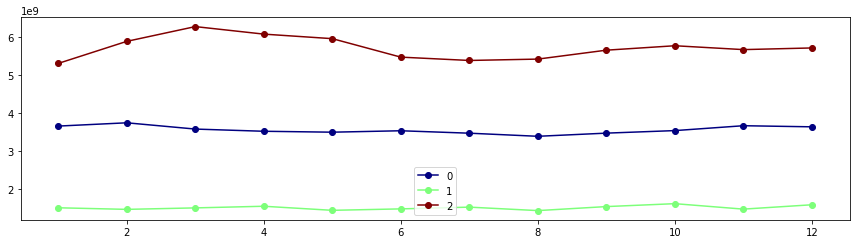

In [56]:
# summary3 - Line Graph for avg volume in each month (cluster wise)
import matplotlib.pylab as pl
from matplotlib.pyplot import figure
#figure(figsize=(15, 5), dpi=80)
plt.rcParams["figure.figsize"] = [12, 3.50]
plt.rcParams["figure.autolayout"] = True
labels = set(summary3['cluster_id'].values)       #{0, 1, 2}
colors = pl.cm.jet(np.linspace(0,1,len(labels)))
for key, color in zip(labels, range(len(labels))):
    data_x = summary3.loc[summary3['cluster_id']==key]['month']
    data_y = summary3.loc[summary3['cluster_id']==key]['Avg_Volume']
    plt.plot(data_x, data_y, marker='o', color=colors[color], label=key)
plt.legend()
plt.show()

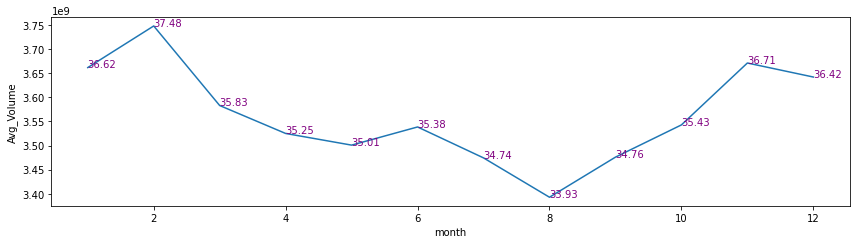

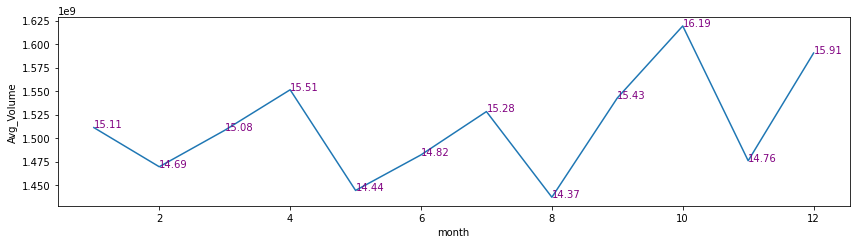

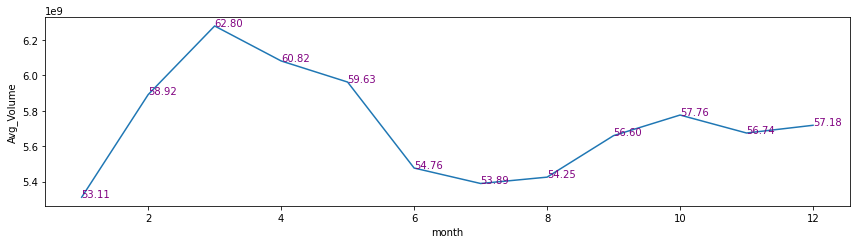

In [57]:
# Summary 3 - month wise avg volume
#plt.figure(figsize=(15, 5))  
cluster0 = summary3.query("cluster_id == 0")
sns.lineplot(data=cluster0, x="month", y="Avg_Volume")
for x, y in zip(cluster0.month, cluster0.Avg_Volume):
    plt.text(x = x, y = y-150, s = '{:.02f}'.format(y/100000000), color = 'purple')
plt.show()

cluster1 = summary3.query("cluster_id == 1")
sns.lineplot(data=cluster1, x="month", y="Avg_Volume")
for x, y in zip(cluster1.month, cluster1.Avg_Volume):
    plt.text(x = x, y = y-150, s = '{:.02f}'.format(y/100000000), color = 'purple')
plt.show()

cluster2 = summary3.query("cluster_id == 2")
sns.lineplot(data=cluster2, x="month", y="Avg_Volume")
for x, y in zip(cluster2.month, cluster2.Avg_Volume):
    plt.text(x = x, y = y-150, s = '{:.02f}'.format(y/100000000), color = 'purple')
plt.show()


Above graphs shows avg volume increases during Aug to Oct months 

In [58]:
#Checking
summary3[(summary3.month.isin([8,10]))]

cluster_id  month  Avg_Volume
7            0      8  3392765491
9            0     10  3542700772
19           1      8  1436978273
21           1     10  1619330413
31           2      8  5424693703
33           2     10  5776025923

In [59]:
(3542700772/3392765491-1)*100

4.419264502593356

In [60]:
(1619330413/1436978273-1)*100

12.689971965915724

In [61]:
(5776025923/5424693703-1)*100

6.476535620908952

In [62]:
market_df_vol.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5220 entries, 0 to 5219
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        5220 non-null   object
 1   Volume      5220 non-null   int64 
 2   cluster_id  5220 non-null   int32 
 3   year        5220 non-null   int64 
 4   month       5220 non-null   int64 
 5   day         5220 non-null   int64 
 6   weekday     5220 non-null   int64 
dtypes: int32(1), int64(5), object(1)
memory usage: 434.9+ KB


In [63]:
# Summary3 - Weekday wise avg volume 
summary3 = market_df_vol.groupby(['cluster_id', 'weekday'])['Volume'].mean().to_frame(name = 'Avg_Volume').reset_index()
summary3['Avg_Volume'] = summary3['Avg_Volume'].astype('int64') 
summary3.head()


cluster_id  weekday  Avg_Volume
0           0        0  3461054916
1           0        1  3590157548
2           0        2  3603972299
3           0        3  3607192321
4           0        4  3524771479

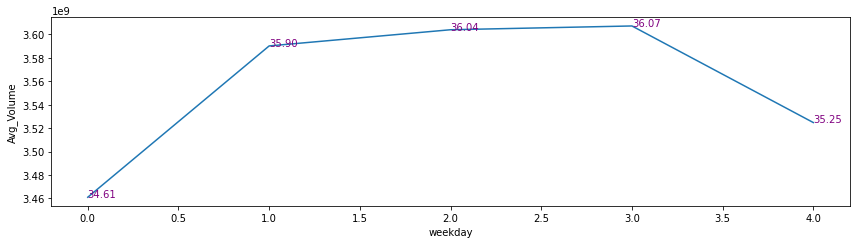

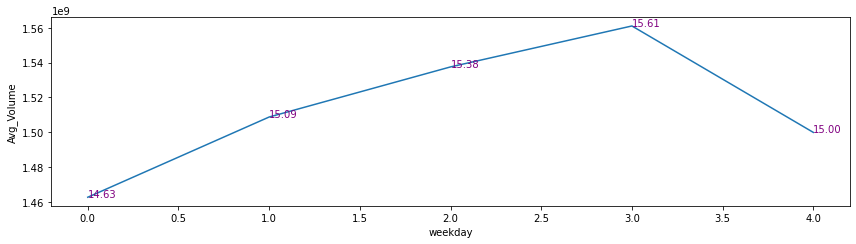

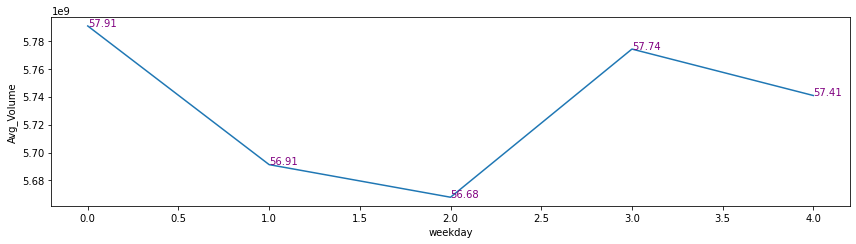

In [64]:
# Summary3 - Weekday wise avg volume  -  Graphs
cluster0 = summary3.query("cluster_id == 0")
sns.lineplot(data=cluster0, x="weekday", y="Avg_Volume")
for x, y in zip(cluster0.weekday, cluster0.Avg_Volume):
    plt.text(x = x, y = y-150, s = '{:.02f}'.format(y/100000000), color = 'purple')
plt.show()

cluster1 = summary3.query("cluster_id == 1")
sns.lineplot(data=cluster1, x="weekday", y="Avg_Volume")
for x, y in zip(cluster1.weekday, cluster1.Avg_Volume):
    plt.text(x = x, y = y-150, s = '{:.02f}'.format(y/100000000), color = 'purple')
plt.show()

cluster2 = summary3.query("cluster_id == 2")
sns.lineplot(data=cluster2, x="weekday", y="Avg_Volume")

for x, y in zip(cluster2.weekday, cluster2.Avg_Volume):
    plt.text(x = x, y = y-150, s = '{:.02f}'.format(y/100000000), color = 'purple')

plt.show()


Above graphs shows avg volume is high on weekday 3 (i.e. Thrusday)

In [66]:
# Summary4 - Year wise avg volume  - (2020 data is incomplete)
summary4 = market_df_vol.groupby(['cluster_id', 'year'])['Volume'].mean().to_frame(name = 'Avg_Volume').reset_index()
summary4['Avg_Volume'] = summary4['Avg_Volume'].astype('int64') 
summary4.head()

cluster_id  year  Avg_Volume
0           0  2002  2642740000
1           0  2005  2681786666
2           0  2006  2760702048
3           0  2007  3233626422
4           0  2008  3951066495

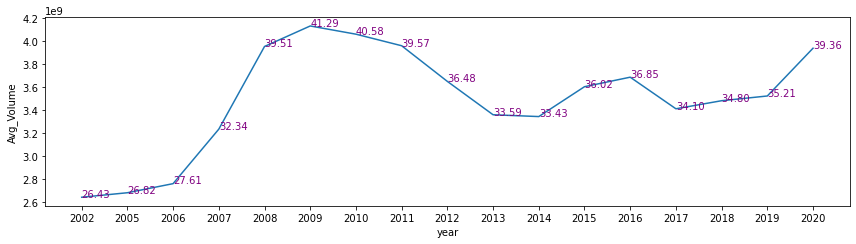

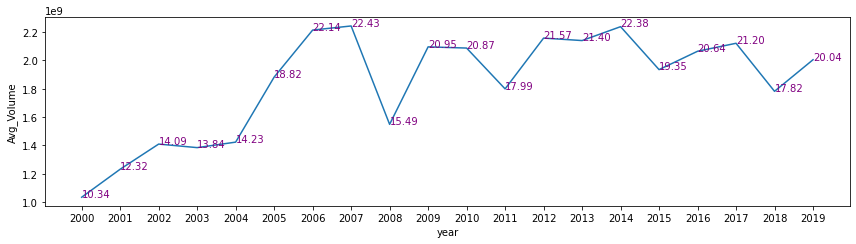

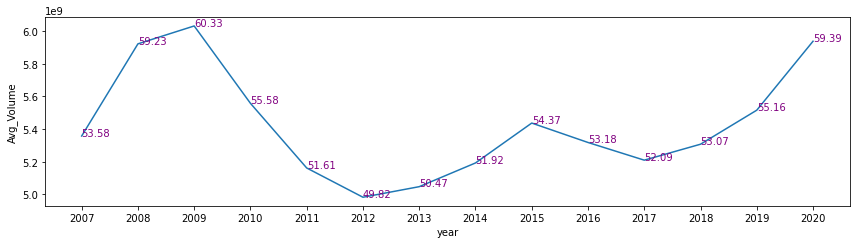

In [68]:
# Summary3 - Weekday wise avg volume  -  Graphs
cluster0 = summary4.query("cluster_id == 0")
cluster0.year.sort_values()
cluster0['year']=cluster0.year.astype(str)
sns.lineplot(data=cluster0, x="year", y="Avg_Volume")
for x, y in zip(cluster0.year, cluster0.Avg_Volume):
    plt.text(x = x, y = y-150, s = '{:.02f}'.format(y/100000000), color = 'purple')
plt.show()

cluster1 = summary4.query("cluster_id == 1")
cluster1.year.sort_values()
cluster1['year']=cluster1.year.astype(str)
sns.lineplot(data=cluster1, x="year", y="Avg_Volume")
for x, y in zip(cluster1.year, cluster1.Avg_Volume):
    plt.text(x = x, y = y-150, s = '{:.02f}'.format(y/100000000), color = 'purple')
plt.show()

cluster2 = summary4.query("cluster_id == 2")
cluster2.year.sort_values()
cluster2['year']=cluster2.year.astype(str)
sns.lineplot(data=cluster2, x="year", y="Avg_Volume")
for x, y in zip(cluster2.year, cluster2.Avg_Volume):
    plt.text(x = x, y = y-150, s = '{:.02f}'.format(y/100000000), color = 'purple')
plt.show()


There was drepession in the year 2008 and 2019. The immediate year shows increase in the volumes

# 

# 

# 

# 

# 

# Part -2

### Examine the daily open, close, and volume data

●	Compute the fractional difference between current day open and previous day open (Parameter 1)

●	Compute the fractional difference between current day open and current day close (Parameter 2)

●	Compute the fractional difference between current day volume and previous day volume (Parameter 3)

How can you cluster the above data set (Parameters 1, 2, 3)?


In [70]:
#Final dataset
market_df_vol.head()

Date      Volume  cluster_id  year  month  day  weekday
0  2000-01-03   931800000           1  2000      1    3        0
1  2000-01-04  1009000000           1  2000      1    4        1
2  2000-01-05  1085500000           1  2000      1    5        2
3  2000-01-06  1092300000           1  2000      1    6        3
4  2000-01-07  1225200000           1  2000      1    7        4

In [71]:
market_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5220 entries, 0 to 5219
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5220 non-null   object 
 1   Open       5220 non-null   float64
 2   High       5220 non-null   float64
 3   Low        5220 non-null   float64
 4   Close      5220 non-null   float64
 5   Adj Close  5220 non-null   float64
 6   Volume     5220 non-null   float64
dtypes: float64(6), object(1)
memory usage: 455.3+ KB


### 3. Prepare the data for modelling (Part 2)

In [73]:
# Computing Paramaters 1,2 & 3 as per the definition
market_df.Date.sort_values().head()
market_df['Prev_Open'] = market_df['Open'].shift(1)

market_df['Prev_Volume'] = market_df['Volume'].shift(1)
market_df.head()

Date         Open         High          Low        Close  \
0  2000-01-03  1469.250000  1478.000000  1438.359985  1455.219971   
1  2000-01-04  1455.219971  1455.219971  1397.430054  1399.420044   
2  2000-01-05  1399.420044  1413.270020  1377.680054  1402.109985   
3  2000-01-06  1402.109985  1411.900024  1392.099976  1403.449951   
4  2000-01-07  1403.449951  1441.469971  1400.729980  1441.469971   

     Adj Close        Volume    Prev_Open   Prev_Volume  
0  1455.219971  9.318000e+08          NaN           NaN  
1  1399.420044  1.009000e+09  1469.250000  9.318000e+08  
2  1402.109985  1.085500e+09  1455.219971  1.009000e+09  
3  1403.449951  1.092300e+09  1399.420044  1.085500e+09  
4  1441.469971  1.225200e+09  1402.109985  1.092300e+09

In [74]:
market_df['Parameter1'] = round((market_df['Open'] - market_df['Prev_Open'])/abs(market_df['Prev_Open']),2)
market_df['Parameter2'] = round((market_df['Open'] - market_df['Close'])/abs(market_df['Close']),2)
market_df['Parameter3'] = round((market_df['Volume'] - market_df['Prev_Volume'])/abs(market_df['Prev_Volume']),2)
market_df.head()

Date         Open         High          Low        Close  \
0  2000-01-03  1469.250000  1478.000000  1438.359985  1455.219971   
1  2000-01-04  1455.219971  1455.219971  1397.430054  1399.420044   
2  2000-01-05  1399.420044  1413.270020  1377.680054  1402.109985   
3  2000-01-06  1402.109985  1411.900024  1392.099976  1403.449951   
4  2000-01-07  1403.449951  1441.469971  1400.729980  1441.469971   

     Adj Close        Volume    Prev_Open   Prev_Volume  Parameter1  \
0  1455.219971  9.318000e+08          NaN           NaN         NaN   
1  1399.420044  1.009000e+09  1469.250000  9.318000e+08       -0.01   
2  1402.109985  1.085500e+09  1455.219971  1.009000e+09       -0.04   
3  1403.449951  1.092300e+09  1399.420044  1.085500e+09        0.00   
4  1441.469971  1.225200e+09  1402.109985  1.092300e+09        0.00   

   Parameter2  Parameter3  
0        0.01         NaN  
1        0.04        0.08  
2       -0.00        0.08  
3       -0.00        0.01  
4       -0.03        0.12

In [75]:
market_df.drop(['Prev_Open','Prev_Volume'], axis = 1)

Date         Open         High          Low        Close  \
0     2000-01-03  1469.250000  1478.000000  1438.359985  1455.219971   
1     2000-01-04  1455.219971  1455.219971  1397.430054  1399.420044   
2     2000-01-05  1399.420044  1413.270020  1377.680054  1402.109985   
3     2000-01-06  1402.109985  1411.900024  1392.099976  1403.449951   
4     2000-01-07  1403.449951  1441.469971  1400.729980  1441.469971   
...          ...          ...          ...          ...          ...   
5215  2020-09-24  3226.139893  3278.699951  3209.449951  3246.590088   
5216  2020-09-25  3236.659912  3306.879883  3228.439941  3298.459961   
5217  2020-09-28  3333.899902  3360.739990  3332.909912  3351.600098   
5218  2020-09-29  3350.919922  3357.919922  3327.540039  3335.469971   
5219  2020-09-30  3341.209961  3393.560059  3340.469971  3363.000000   

        Adj Close        Volume  Parameter1  Parameter2  Parameter3  
0     1455.219971  9.318000e+08         NaN        0.01         NaN  
1     1399.420044  1.009000e+09       -0.01        0.04        0.08  
2     1402.109985  1.085500e+09       -0.04       -0.00        0.08  
3     1403.449951  1.092300e+09        0.00       -0.00        0.01  
4     1441.469971  1.225200e+09        0.00       -0.03        0.12  
...           ...           ...         ...         ...         ...  
5215  3246.590088  4.599470e+09       -0.03       -0.01        0.05  
5216  3298.459961  3.792220e+09        0.00       -0.02       -0.18  
5217  3351.600098  3.946060e+09        0.03       -0.01        0.04  
5218  3335.469971  3.651880e+09        0.01        0.00       -0.07  
5219  3363.000000  4.722530e+09       -0.00       -0.01        0.29  

[5220 rows x 10 columns]

In [77]:
market_df = market_df.drop([0]).reset_index(drop = True)
market_df.head()

Date         Open         High          Low        Close  \
0  2000-01-04  1455.219971  1455.219971  1397.430054  1399.420044   
1  2000-01-05  1399.420044  1413.270020  1377.680054  1402.109985   
2  2000-01-06  1402.109985  1411.900024  1392.099976  1403.449951   
3  2000-01-07  1403.449951  1441.469971  1400.729980  1441.469971   
4  2000-01-10  1441.469971  1464.359985  1441.469971  1457.599976   

     Adj Close        Volume    Prev_Open   Prev_Volume  Parameter1  \
0  1399.420044  1.009000e+09  1469.250000  9.318000e+08       -0.01   
1  1402.109985  1.085500e+09  1455.219971  1.009000e+09       -0.04   
2  1403.449951  1.092300e+09  1399.420044  1.085500e+09        0.00   
3  1441.469971  1.225200e+09  1402.109985  1.092300e+09        0.00   
4  1457.599976  1.064800e+09  1403.449951  1.225200e+09        0.03   

   Parameter2  Parameter3  
0        0.04        0.08  
1       -0.00        0.08  
2       -0.00        0.01  
3       -0.03        0.12  
4       -0.01       -0.13

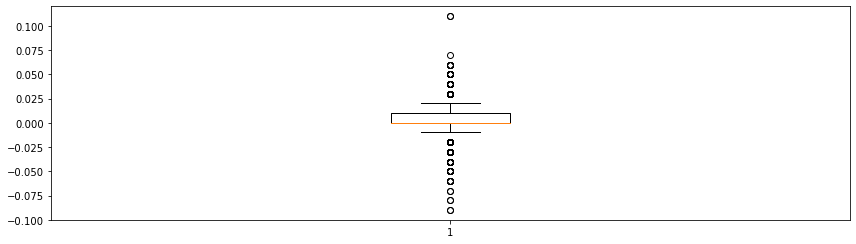

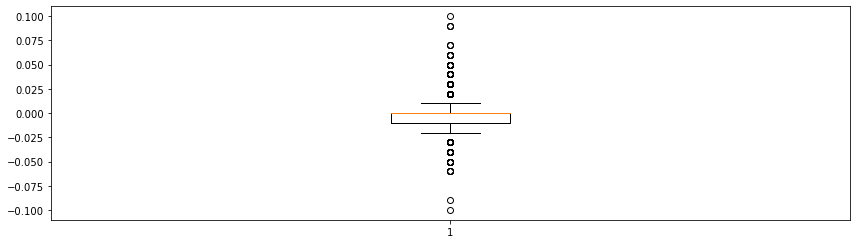

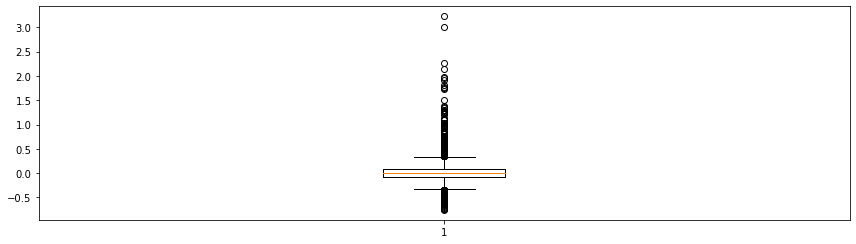

In [78]:
#Visulaising Parameter vaiables
plt.boxplot(market_df['Parameter1'])
plt.show()
plt.boxplot(market_df['Parameter2'])
plt.show()
plt.boxplot(market_df['Parameter3'])
plt.show()

In [79]:
# Treating (statistical) outliers

Q1 = market_df.Parameter1.quantile(0.05)
Q3 = market_df.Parameter1.quantile(0.95)
IQR = Q3 - Q1
# grouped_df = grouped_df[(market_df.Parameter1 >= Q1 - 1.5*IQR) & (market_df.Parameter1 <= Q3 + 1.5*IQR)]
market_df['Parameter1'] = np.where((market_df['Parameter1'] > (Q1 + 1.5*IQR)), (Q1 + 1.5*IQR), market_df['Parameter1'])
market_df['Parameter1'] = np.where((market_df['Parameter1'] < (Q1 - 1.5*IQR)), (Q1 - 1.5*IQR), market_df['Parameter1'])

# outlier treatment for Parameter2
Q1 = market_df.Parameter2.quantile(0.05)
Q3 = market_df.Parameter2.quantile(0.95)
IQR = Q3 - Q1
market_df['Parameter2'] = np.where((market_df['Parameter2'] > (Q1 + 1.5*IQR)), (Q1 + 1.5*IQR), market_df['Parameter2'])
market_df['Parameter2'] = np.where((market_df['Parameter2'] < (Q1 - 1.5*IQR)), (Q1 - 1.5*IQR), market_df['Parameter2'])

# outlier treatment for Parameter3
Q1 = market_df.Parameter3.quantile(0.05)
Q3 = market_df.Parameter3.quantile(0.95)
IQR = Q3 - Q1
market_df['Parameter3'] = np.where((market_df['Parameter3'] > (Q1 + 1.5*IQR)), (Q1 + 1.5*IQR), market_df['Parameter3'])
market_df['Parameter3'] = np.where((market_df['Parameter3'] < (Q1 - 1.5*IQR)), (Q1 - 1.5*IQR), market_df['Parameter3'])


### Using Hopkins statistic - is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

In [80]:
# Data Analyses on Parameter1,2 & 3
mkt_param_scaled = market_df[['Parameter1','Parameter2','Parameter3']]
mkt_param_scaled.head()

Parameter1  Parameter2  Parameter3
0       -0.01        0.04        0.08
1       -0.04       -0.00        0.08
2        0.00       -0.00        0.01
3        0.00       -0.03        0.12
4        0.03       -0.01       -0.13

In [81]:
#Using Hopkins Statistic function by passing the mkt_param_scaled dataframe as a paramter
hopkins(mkt_param_scaled)

0.9462705659525892

### 4. Modeling - k-means Clustering

In [82]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=3, max_iter=200)
kmeans.fit(mkt_param_scaled)

KMeans(max_iter=200, n_clusters=3)

In [83]:
kmeans.labels_

array([0, 0, 0, ..., 0, 1, 2], dtype=int32)

In [86]:
market_df_param = market_df[['Date','Parameter1','Parameter2','Parameter3','Volume']]
market_df_param['Volume'] = market_df_param['Volume'].astype('int64') 
market_df_param.head()

Date  Parameter1  Parameter2  Parameter3      Volume
0  2000-01-04       -0.01        0.04        0.08  1009000000
1  2000-01-05       -0.04       -0.00        0.08  1085500000
2  2000-01-06        0.00       -0.00        0.01  1092300000
3  2000-01-07        0.00       -0.03        0.12  1225200000
4  2000-01-10        0.03       -0.01       -0.13  1064800000

In [87]:
# market_df_param.shape
market_df.head()

Date         Open         High          Low        Close  \
0  2000-01-04  1455.219971  1455.219971  1397.430054  1399.420044   
1  2000-01-05  1399.420044  1413.270020  1377.680054  1402.109985   
2  2000-01-06  1402.109985  1411.900024  1392.099976  1403.449951   
3  2000-01-07  1403.449951  1441.469971  1400.729980  1441.469971   
4  2000-01-10  1441.469971  1464.359985  1441.469971  1457.599976   

     Adj Close        Volume    Prev_Open   Prev_Volume  Parameter1  \
0  1399.420044  1.009000e+09  1469.250000  9.318000e+08       -0.01   
1  1402.109985  1.085500e+09  1455.219971  1.009000e+09       -0.04   
2  1403.449951  1.092300e+09  1399.420044  1.085500e+09        0.00   
3  1441.469971  1.225200e+09  1402.109985  1.092300e+09        0.00   
4  1457.599976  1.064800e+09  1403.449951  1.225200e+09        0.03   

   Parameter2  Parameter3  
0        0.04        0.08  
1       -0.00        0.08  
2       -0.00        0.01  
3       -0.03        0.12  
4       -0.01       -0.13

In [88]:
# assigning the label
market_df_param['cluster_id'] = kmeans.labels_
market_df_param.head()

Date  Parameter1  Parameter2  Parameter3      Volume  cluster_id
0  2000-01-04       -0.01        0.04        0.08  1009000000           0
1  2000-01-05       -0.04       -0.00        0.08  1085500000           0
2  2000-01-06        0.00       -0.00        0.01  1092300000           0
3  2000-01-07        0.00       -0.03        0.12  1225200000           0
4  2000-01-10        0.03       -0.01       -0.13  1064800000           1

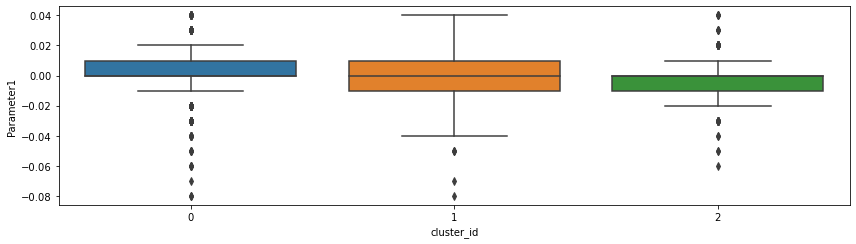

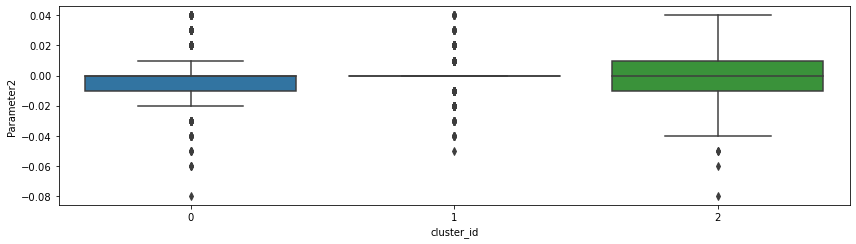

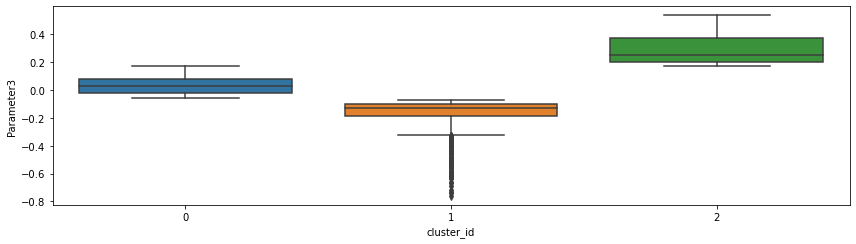

In [89]:
# plot - fractional difference between current day open and previous day open 
sns.boxplot(x='cluster_id', y='Parameter1', data=market_df_param)
plt.show()
# plot - fractional difference between current day open and current day close
sns.boxplot(x='cluster_id', y='Parameter2', data=market_df_param)
plt.show()
# plot - fractional difference between current day volume and previous day volume
sns.boxplot(x='cluster_id', y='Parameter3', data=market_df_param)
plt.show()

#### Finding the optimal number of clusters

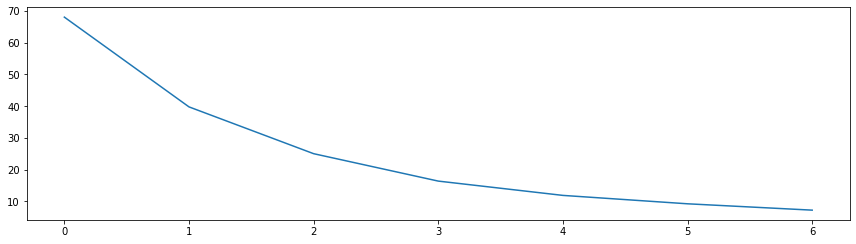

In [90]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(mkt_param_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

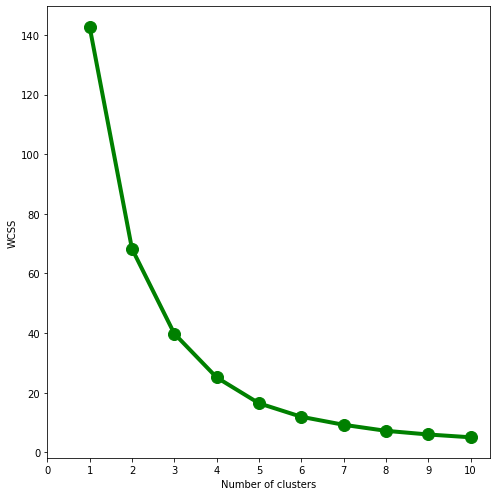

In [92]:
#elbow method
x = market_df[['Parameter1','Parameter2','Parameter3']].values

WCSS = []
for i in range(1,11):
    model = KMeans(n_clusters = i,init = 'k-means++')
    model.fit(x)
    WCSS.append(model.inertia_)
fig = plt.figure(figsize = (7,7))
plt.plot(range(1,11),WCSS, linewidth=4, markersize=12,marker='o',color = 'green')
plt.xticks(np.arange(11))
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [99]:
# since elbow occured at 5, hence the optimal number of clusters for the mall data is 5 
model = KMeans(n_clusters = 3, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0) # N_cluster = 3 (better distribution)
y_clusters = model.fit_predict(x)

<AxesSubplot:ylabel='count'>

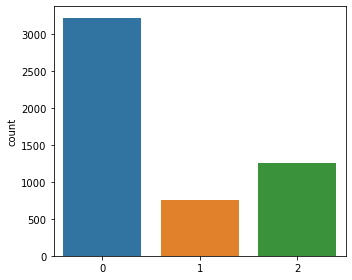

In [100]:
# countplot to check the number of clusters and number of customers in each cluster
plt.figure(figsize = (5,4))
sns.countplot(y_clusters)

In [101]:
# cluster 0 - x,y,z axis
print(x[y_clusters == 0,0][1])
print(x[y_clusters == 0,1][1])
print(x[y_clusters == 0,2][1])
# print(x[y_clusters == 0,3][1])
# print(x[y_clusters == 0,4][1])

-0.04
-0.0
0.08


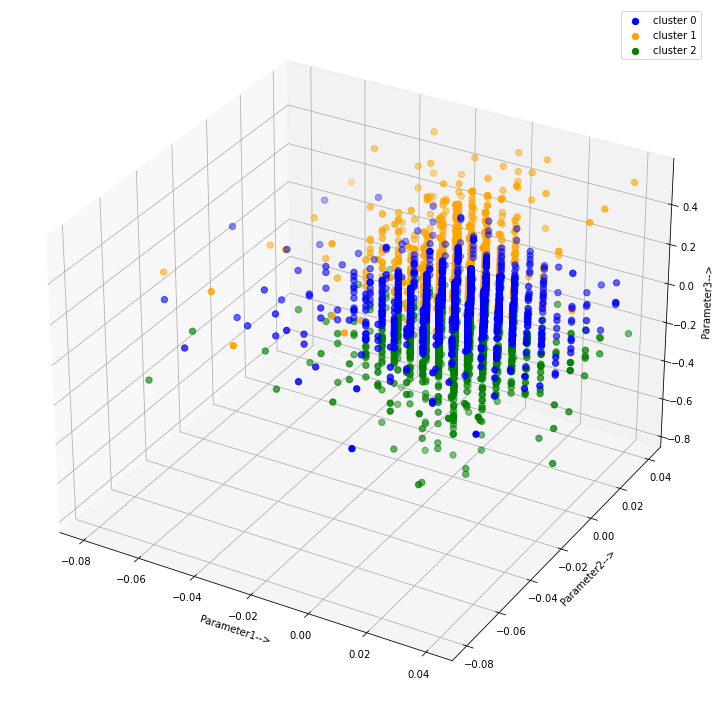

In [102]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[y_clusters == 0,0],x[y_clusters == 0,1],x[y_clusters == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(x[y_clusters == 1,0],x[y_clusters == 1,1],x[y_clusters == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(x[y_clusters == 2,0],x[y_clusters == 2,1],x[y_clusters == 2,2], s = 40 , color = 'green', label = "cluster 2")
# ax.scatter(x[y_clusters == 3,0],x[y_clusters == 3,1],x[y_clusters == 3,2], s = 40 , color = '#D12B60', label = "cluster 3")
# ax.scatter(x[y_clusters == 4,0],x[y_clusters == 4,1],x[y_clusters == 4,2], s = 40 , color = 'purple', label = "cluster 4")
ax.set_xlabel('Parameter1-->')
ax.set_ylabel('Parameter2-->')
ax.set_zlabel('Parameter3-->')
ax.legend()
plt.show()

In [103]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(mkt_param_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(mkt_param_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.4929979433856606
For n_clusters=3, the silhouette score is 0.48919911000931343
For n_clusters=4, the silhouette score is 0.49321996025050996
For n_clusters=5, the silhouette score is 0.4900008116945084
For n_clusters=6, the silhouette score is 0.47743672603478793
For n_clusters=7, the silhouette score is 0.46718601364005263
For n_clusters=8, the silhouette score is 0.46445653002839216


In [106]:
# model with k=3
kmeans = KMeans(n_clusters=3, max_iter=200)
kmeans.fit(mkt_param_scaled)

KMeans(max_iter=200, n_clusters=3)

In [107]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 2], dtype=int32)

In [108]:
market_df_param = market_df[['Date','Parameter1','Parameter2','Parameter3','Volume']]

In [110]:
# assigning the label
market_df_param['cluster_id'] = kmeans.labels_
market_df_param.head()

Date  Parameter1  Parameter2  Parameter3        Volume  cluster_id
0  2000-01-04       -0.01        0.04        0.08  1.009000e+09           0
1  2000-01-05       -0.04       -0.00        0.08  1.085500e+09           0
2  2000-01-06        0.00       -0.00        0.01  1.092300e+09           0
3  2000-01-07        0.00       -0.03        0.12  1.225200e+09           0
4  2000-01-10        0.03       -0.01       -0.13  1.064800e+09           1

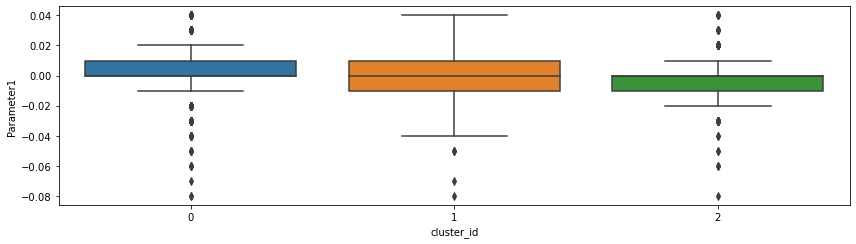

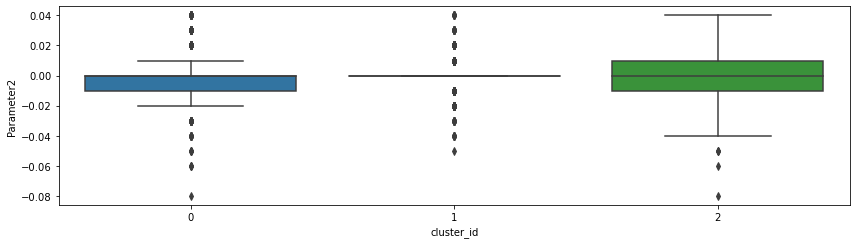

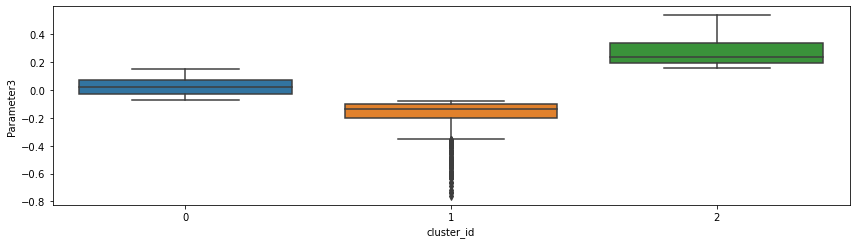

In [111]:
# plot - fractional difference between current day open and previous day open 
sns.boxplot(x='cluster_id', y='Parameter1', data=market_df_param)
plt.show()
# plot - fractional difference between current day open and current day close
sns.boxplot(x='cluster_id', y='Parameter2', data=market_df_param)
plt.show()
# plot - fractional difference between current day volume and previous day volume
sns.boxplot(x='cluster_id', y='Parameter3', data=market_df_param)
plt.show()

In [112]:
# model with k=3,5,6
kmeans = KMeans(n_clusters=6, max_iter=200)
kmeans.fit(mkt_param_scaled)

KMeans(max_iter=200, n_clusters=6)

In [113]:
kmeans.labels_

array([2, 2, 5, ..., 2, 5, 0], dtype=int32)

In [114]:
market_df_param = market_df[['Date','Parameter1','Parameter2','Parameter3','Volume']]

In [115]:
# assigning the label
market_df_param['cluster_id'] = kmeans.labels_
market_df_param.head()

Date  Parameter1  Parameter2  Parameter3        Volume  cluster_id
0  2000-01-04       -0.01        0.04        0.08  1.009000e+09           2
1  2000-01-05       -0.04       -0.00        0.08  1.085500e+09           2
2  2000-01-06        0.00       -0.00        0.01  1.092300e+09           5
3  2000-01-07        0.00       -0.03        0.12  1.225200e+09           2
4  2000-01-10        0.03       -0.01       -0.13  1.064800e+09           1

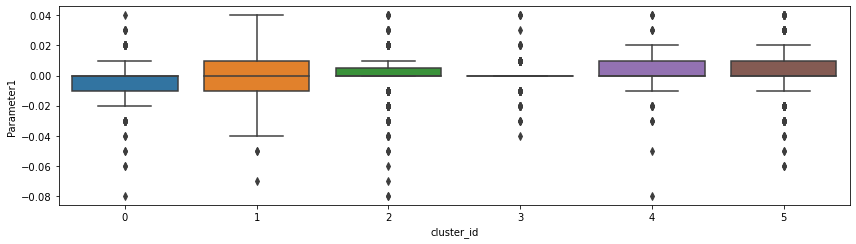

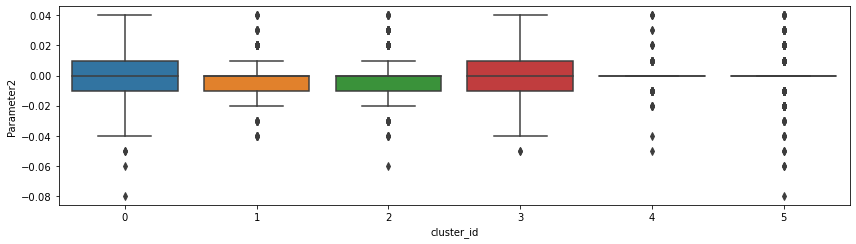

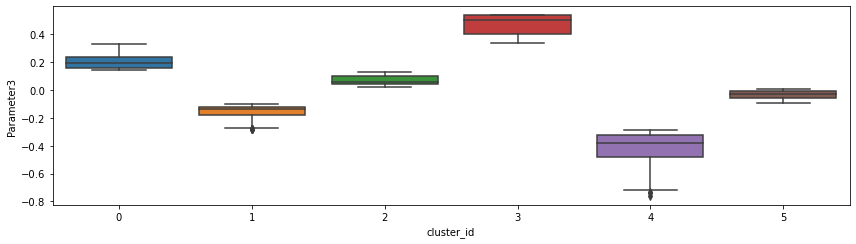

In [116]:
# plot - fractional difference between current day open and previous day open 
sns.boxplot(x='cluster_id', y='Parameter1', data=market_df_param)
plt.show()
# plot - fractional difference between current day open and current day close
sns.boxplot(x='cluster_id', y='Parameter2', data=market_df_param)
plt.show()
# plot - fractional difference between current day volume and previous day volume
sns.boxplot(x='cluster_id', y='Parameter3', data=market_df_param)
plt.show()

In [117]:
market_df_param.cluster_id.value_counts()

5    1741
2    1451
1     975
0     700
3     196
4     156
Name: cluster_id, dtype: int64

In [118]:
425/5219

0.08143322475570032

## Hierarchical Clustering

In [119]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [120]:
market_df_param.head()

Date  Parameter1  Parameter2  Parameter3        Volume  cluster_id
0  2000-01-04       -0.01        0.04        0.08  1.009000e+09           2
1  2000-01-05       -0.04       -0.00        0.08  1.085500e+09           2
2  2000-01-06        0.00       -0.00        0.01  1.092300e+09           5
3  2000-01-07        0.00       -0.03        0.12  1.225200e+09           2
4  2000-01-10        0.03       -0.01       -0.13  1.064800e+09           1

In [121]:
mkt_param_scaled.head()

Parameter1  Parameter2  Parameter3
0       -0.01        0.04        0.08
1       -0.04       -0.00        0.08
2        0.00       -0.00        0.01
3        0.00       -0.03        0.12
4        0.03       -0.01       -0.13

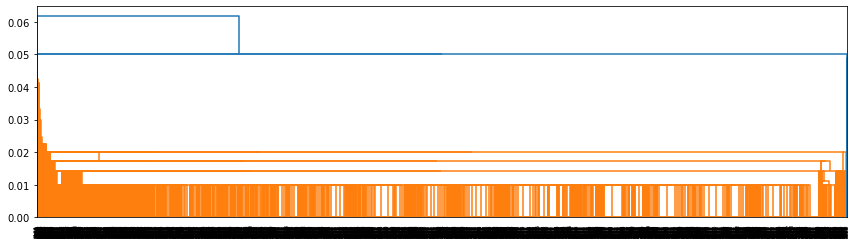

In [122]:
# single linkage - min dist b/w 2 points into clusters
mergings = linkage(mkt_param_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

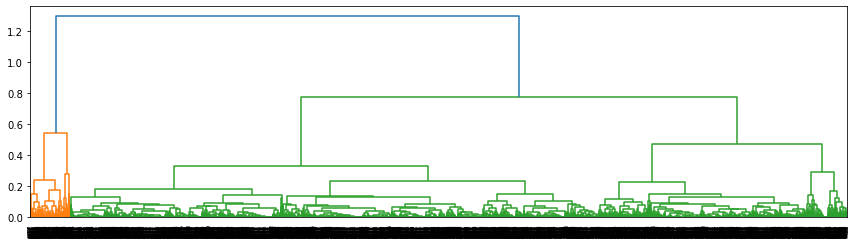

In [124]:
# complete linkage - max dist # 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
#cluster_labels b/w 2 points into clusters
mergings = linkage(mkt_param_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [125]:
# 5 clusters
cluster_labels = cut_tree(mergings, n_clusters=5).reshape(-1, )
cluster_labels

array([0, 1, 1, ..., 1, 1, 0])

In [126]:
# assign cluster labels
market_df_param['cluster_labels'] = cluster_labels
market_df_param.head()

Date  Parameter1  Parameter2  Parameter3        Volume  cluster_id  \
0  2000-01-04       -0.01        0.04        0.08  1.009000e+09           2   
1  2000-01-05       -0.04       -0.00        0.08  1.085500e+09           2   
2  2000-01-06        0.00       -0.00        0.01  1.092300e+09           5   
3  2000-01-07        0.00       -0.03        0.12  1.225200e+09           2   
4  2000-01-10        0.03       -0.01       -0.13  1.064800e+09           1   

   cluster_labels  
0               0  
1               1  
2               1  
3               0  
4               1

<AxesSubplot:xlabel='cluster_labels', ylabel='Parameter1'>

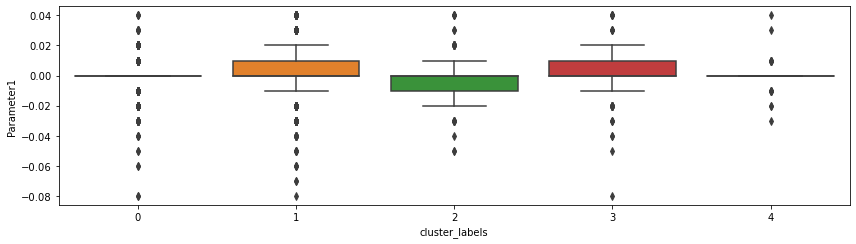

In [127]:
# plot - difference between current day open and previous day open
sns.boxplot(x='cluster_labels', y='Parameter1', data=market_df_param)

<AxesSubplot:xlabel='cluster_labels', ylabel='Parameter2'>

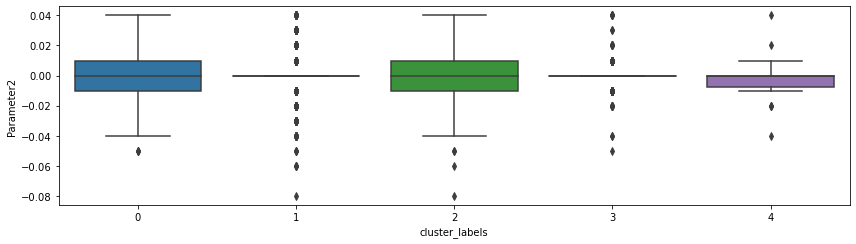

In [128]:
# plot - difference between current day open and current day close
sns.boxplot(x='cluster_labels', y='Parameter2', data=market_df_param)

<AxesSubplot:xlabel='cluster_labels', ylabel='Parameter3'>

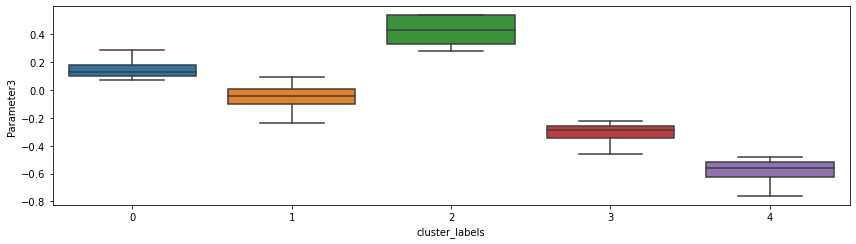

In [129]:
# plot - difference between current day volume and previous day volume 
sns.boxplot(x='cluster_labels', y='Parameter3', data=market_df_param)

<AxesSubplot:xlabel='cluster_labels', ylabel='Volume'>

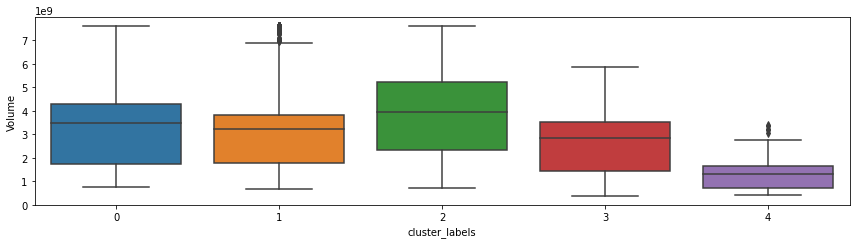

In [130]:
#plot -  volume distribution based on cluster labels
sns.boxplot(x='cluster_labels', y='Volume', data=market_df_param)

### Analysis 2 - Daily volume analysis data

In [131]:
#Final dataset
market_df_vol.head()

Date      Volume  cluster_id  year  month  day  weekday
0  2000-01-03   931800000           1  2000      1    3        0
1  2000-01-04  1009000000           1  2000      1    4        1
2  2000-01-05  1085500000           1  2000      1    5        2
3  2000-01-06  1092300000           1  2000      1    6        3
4  2000-01-07  1225200000           1  2000      1    7        4

In [132]:
market_df.head()

Date         Open         High          Low        Close  \
0  2000-01-04  1455.219971  1455.219971  1397.430054  1399.420044   
1  2000-01-05  1399.420044  1413.270020  1377.680054  1402.109985   
2  2000-01-06  1402.109985  1411.900024  1392.099976  1403.449951   
3  2000-01-07  1403.449951  1441.469971  1400.729980  1441.469971   
4  2000-01-10  1441.469971  1464.359985  1441.469971  1457.599976   

     Adj Close        Volume    Prev_Open   Prev_Volume  Parameter1  \
0  1399.420044  1.009000e+09  1469.250000  9.318000e+08       -0.01   
1  1402.109985  1.085500e+09  1455.219971  1.009000e+09       -0.04   
2  1403.449951  1.092300e+09  1399.420044  1.085500e+09        0.00   
3  1441.469971  1.225200e+09  1402.109985  1.092300e+09        0.00   
4  1457.599976  1.064800e+09  1403.449951  1.225200e+09        0.03   

   Parameter2  Parameter3  
0        0.04        0.08  
1       -0.00        0.08  
2       -0.00        0.01  
3       -0.03        0.12  
4       -0.01       -0.13

In [133]:
market_param = market_df.drop(['Volume','Prev_Open','Prev_Volume'], axis = 1)
market_param.head()

Date         Open         High          Low        Close  \
0  2000-01-04  1455.219971  1455.219971  1397.430054  1399.420044   
1  2000-01-05  1399.420044  1413.270020  1377.680054  1402.109985   
2  2000-01-06  1402.109985  1411.900024  1392.099976  1403.449951   
3  2000-01-07  1403.449951  1441.469971  1400.729980  1441.469971   
4  2000-01-10  1441.469971  1464.359985  1441.469971  1457.599976   

     Adj Close  Parameter1  Parameter2  Parameter3  
0  1399.420044       -0.01        0.04        0.08  
1  1402.109985       -0.04       -0.00        0.08  
2  1403.449951        0.00       -0.00        0.01  
3  1441.469971        0.00       -0.03        0.12  
4  1457.599976        0.03       -0.01       -0.13

In [134]:
# Merging Market data and Parameter dataframes
market_param_da = pd.merge(market_df_vol, market_param, on="Date", how="inner")
market_param_da.head()

Date      Volume  cluster_id  year  month  day  weekday         Open  \
0  2000-01-04  1009000000           1  2000      1    4        1  1455.219971   
1  2000-01-05  1085500000           1  2000      1    5        2  1399.420044   
2  2000-01-06  1092300000           1  2000      1    6        3  1402.109985   
3  2000-01-07  1225200000           1  2000      1    7        4  1403.449951   
4  2000-01-10  1064800000           1  2000      1   10        0  1441.469971   

          High          Low        Close    Adj Close  Parameter1  Parameter2  \
0  1455.219971  1397.430054  1399.420044  1399.420044       -0.01        0.04   
1  1413.270020  1377.680054  1402.109985  1402.109985       -0.04       -0.00   
2  1411.900024  1392.099976  1403.449951  1403.449951        0.00       -0.00   
3  1441.469971  1400.729980  1441.469971  1441.469971        0.00       -0.03   
4  1464.359985  1441.469971  1457.599976  1457.599976        0.03       -0.01   

   Parameter3  
0        0.08  
1        0.08  
2        0.01  
3        0.12  
4       -0.13

In [146]:
market_param_da.cluster_id.value_counts()

0    2740
1    1777
2     702
Name: cluster_id, dtype: int64

In [148]:
# Creating cluster wise dataframe

cluster0 = market_param_da.loc[market_param_da.cluster_id==0]
cluster0_scaled = cluster0[['Parameter1','Parameter2','Parameter3']]
print(cluster0_scaled.shape)

cluster1 = market_param_da.loc[market_param_da.cluster_id==1]
cluster1_scaled = cluster1[['Parameter1','Parameter2','Parameter3']]

cluster2 = market_param_da.loc[market_param_da.cluster_id==2]
cluster2_scaled = cluster2[['Parameter1','Parameter2','Parameter3']]
cluster2_scaled.head()

(2740, 3)


Parameter1  Parameter2  Parameter3
1900       -0.02        0.02        0.07
1903       -0.01       -0.01        0.16
1906       -0.03       -0.02        0.19
1907        0.02       -0.01       -0.03
1908        0.01       -0.01        0.12

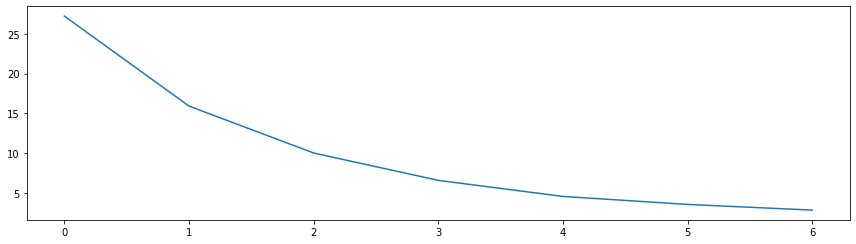

In [149]:
# elbow-curve/SSD -  For cluster 0 
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(cluster0_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

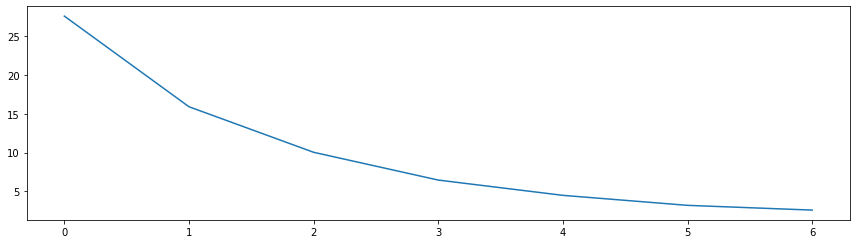

In [150]:
# elbow-curve/SSD -  For cluster 1
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(cluster1_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

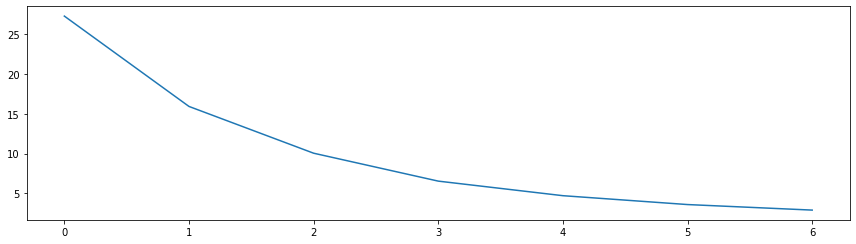

In [151]:
# elbow-curve/SSD -  For cluster 2
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(cluster0_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

In [152]:
cluster0_scaled.tail()

Parameter1  Parameter2  Parameter3
5213        0.01        0.03        0.10
5214       -0.03       -0.01        0.05
5215        0.00       -0.02       -0.18
5216        0.03       -0.01        0.04
5217        0.01        0.00       -0.07

In [153]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=200)
    kmeans.fit(cluster0_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(cluster0_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.510017167064253
For n_clusters=3, the silhouette score is 0.49819615846801785
For n_clusters=4, the silhouette score is 0.49876139295255395
For n_clusters=5, the silhouette score is 0.5017127038384747
For n_clusters=6, the silhouette score is 0.4939519491297553
For n_clusters=7, the silhouette score is 0.4779342713823836
For n_clusters=8, the silhouette score is 0.46415156318569767


In [154]:
# silhouette analysis -  For Cluster 1
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=500)
    kmeans.fit(cluster1_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(cluster1_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.47802519797142606
For n_clusters=3, the silhouette score is 0.5171485729893445
For n_clusters=4, the silhouette score is 0.5002774852206784
For n_clusters=5, the silhouette score is 0.49292465923847917
For n_clusters=6, the silhouette score is 0.4807107927302255
For n_clusters=7, the silhouette score is 0.47814310956022643
For n_clusters=8, the silhouette score is 0.4612205411326813


In [155]:
# silhouette analysis -  For Cluster 1
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=500)
    kmeans.fit(cluster2_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(cluster2_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5392099466958153
For n_clusters=3, the silhouette score is 0.49439572280097166
For n_clusters=4, the silhouette score is 0.4925806730576932
For n_clusters=5, the silhouette score is 0.46960328522366773
For n_clusters=6, the silhouette score is 0.4326147764843368
For n_clusters=7, the silhouette score is 0.4093166579076349
For n_clusters=8, the silhouette score is 0.39106890244147263


In [156]:
kmeans = KMeans(n_clusters=3, max_iter=100)
kmeans.fit(cluster0_scaled)

KMeans(max_iter=100, n_clusters=3)

In [157]:
# assigning the label
cluster0['cluster_labels'] = kmeans.labels_
cluster0.head()

Date      Volume  cluster_id  year  month  day  weekday  \
632   2002-07-15  2574800000           0  2002      7   15        0   
634   2002-07-17  2566500000           0  2002      7   17        2   
636   2002-07-19  2654100000           0  2002      7   19        4   
639   2002-07-24  2775560000           0  2002      7   24        2   
1326  2005-04-15  2689960000           0  2005      4   15        4   

             Open         High          Low        Close    Adj Close  \
632    921.390015   921.390015   876.460022   917.929993   917.929993   
634    901.049988   926.520020   895.030029   906.039978   906.039978   
636    881.559998   881.559998   842.070007   847.750000   847.750000   
639    797.710022   844.320007   775.679993   843.429993   843.429993   
1326  1162.050049  1162.050049  1141.920044  1142.619995  1142.619995   

      Parameter1  Parameter2  Parameter3  cluster_labels  
632        -0.01        0.00       0.535               2  
634        -0.02       -0.01       0.390               2  
636        -0.03        0.04       0.530               2  
639        -0.03       -0.05       0.140               2  
1326       -0.01        0.02       0.140               2

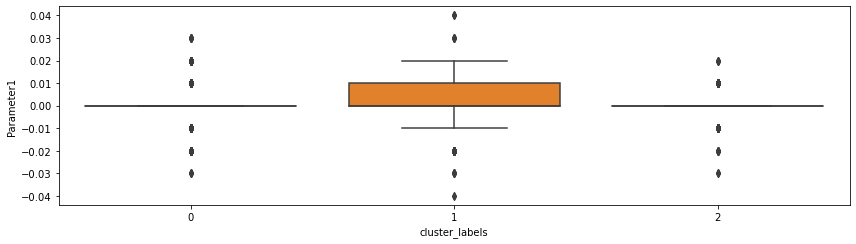

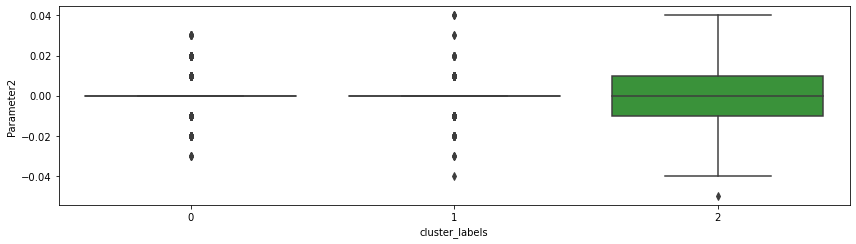

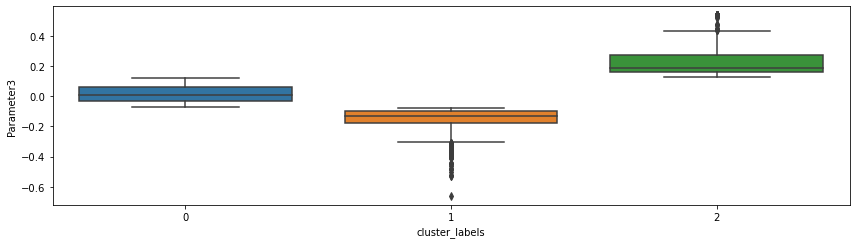

In [158]:
# plot
sns.boxplot(x='cluster_labels', y='Parameter1', data=cluster0)
plt.show()
sns.boxplot(x='cluster_labels', y='Parameter2', data=cluster0)
plt.show()
sns.boxplot(x='cluster_labels', y='Parameter3', data=cluster0)
plt.show()

# 






# 











# 











# 













## Part - 3
#### ●	For the data set, compute the monthly returns i.e., fractional difference between the month’s closing price and opening price
#### ●	Use decision tree to classify if investing in any month can be a profitable strategy
#### ●	What are the error metrics of your model? 

In [159]:
market_param_da.head()

Date      Volume  cluster_id  year  month  day  weekday         Open  \
0  2000-01-04  1009000000           1  2000      1    4        1  1455.219971   
1  2000-01-05  1085500000           1  2000      1    5        2  1399.420044   
2  2000-01-06  1092300000           1  2000      1    6        3  1402.109985   
3  2000-01-07  1225200000           1  2000      1    7        4  1403.449951   
4  2000-01-10  1064800000           1  2000      1   10        0  1441.469971   

          High          Low        Close    Adj Close  Parameter1  Parameter2  \
0  1455.219971  1397.430054  1399.420044  1399.420044       -0.01        0.04   
1  1413.270020  1377.680054  1402.109985  1402.109985       -0.04       -0.00   
2  1411.900024  1392.099976  1403.449951  1403.449951        0.00       -0.00   
3  1441.469971  1400.729980  1441.469971  1441.469971        0.00       -0.03   
4  1464.359985  1441.469971  1457.599976  1457.599976        0.03       -0.01   

   Parameter3  
0        0.08  
1        0.08  
2        0.01  
3        0.12  
4       -0.13

In [160]:
market_param_da.shape

(5219, 15)

In [161]:
# Dropping date column
market_param_da.sort_values(by=['Date'],inplace=True)

In [162]:
# Month's closing price
month_close_df = market_param_da.groupby(['year','month']).tail(1) # last record of every month
month_close_df.rename(columns = {'Open': 'Mnth_End_Open', 'High': 'Mnth_End_High', 'Low':'Mnth_End_Low', 
                                'Close' : 'Mnth_End_Close', 'Volume' : 'Mnth_End_Volume'}, inplace = True)
month_close_df = month_close_df.drop(columns=['day','cluster_id','weekday','Adj Close','Parameter1','Parameter2',
                                            'Parameter3'],axis=1)
month_close_df.head()

Date  Mnth_End_Volume  year  month  Mnth_End_Open  Mnth_End_High  \
18   2000-01-31        993800000  2000      1    1360.160034    1394.479980   
38   2000-02-29       1204300000  2000      2    1348.050049    1369.630005   
61   2000-03-31       1227400000  2000      3    1487.920044    1519.810059   
80   2000-04-28        984600000  2000      4    1464.920044    1473.619995   
102  2000-05-31        960500000  2000      5    1422.439941    1434.489990   

     Mnth_End_Low  Mnth_End_Close  
18    1350.140015     1394.459961  
38    1348.050049     1366.420044  
61    1484.380005     1498.579956  
80    1448.150024     1452.430054  
102   1415.500000     1420.599976

In [163]:
# Month's opening price
month_open_df = market_param_da.groupby(['year','month']).head(1) # first record of every month
month_open_df.rename(columns = {'Open': 'Mnth_Start_Open', 'High': 'Mnth_Start_High', 'Low':'Mnth_Start_Low', 
                                'Close' : 'Mnth_Start_Close', 'Volume' : 'Mnth_Start_Volume'}, inplace = True)
month_open_df = month_open_df.drop(columns=['day','cluster_id','weekday','Adj Close','Parameter1','Parameter2',
                                            'Parameter3'],axis=1)
month_open_df.head()

Date  Mnth_Start_Volume  year  month  Mnth_Start_Open  \
0   2000-01-04         1009000000  2000      1      1455.219971   
19  2000-02-01          981000000  2000      2      1394.459961   
39  2000-03-01         1274100000  2000      3      1366.420044   
62  2000-04-03         1021700000  2000      4      1498.579956   
81  2000-05-01          966300000  2000      5      1452.430054   

    Mnth_Start_High  Mnth_Start_Low  Mnth_Start_Close  
0       1455.219971     1397.430054       1399.420044  
19      1412.489990     1384.790039       1409.280029  
39      1383.459961     1366.420044       1379.189941  
62      1507.189941     1486.959961       1505.969971  
81      1481.510010     1452.430054       1468.250000

In [164]:
# Combining month's closing and opening price to compute fractional difference
monthly_lvl_df = pd.merge(month_open_df, month_close_df, on=['year','month'], how="inner")
monthly_lvl_df.head()

Date_x  Mnth_Start_Volume  year  month  Mnth_Start_Open  \
0  2000-01-04         1009000000  2000      1      1455.219971   
1  2000-02-01          981000000  2000      2      1394.459961   
2  2000-03-01         1274100000  2000      3      1366.420044   
3  2000-04-03         1021700000  2000      4      1498.579956   
4  2000-05-01          966300000  2000      5      1452.430054   

   Mnth_Start_High  Mnth_Start_Low  Mnth_Start_Close      Date_y  \
0      1455.219971     1397.430054       1399.420044  2000-01-31   
1      1412.489990     1384.790039       1409.280029  2000-02-29   
2      1383.459961     1366.420044       1379.189941  2000-03-31   
3      1507.189941     1486.959961       1505.969971  2000-04-28   
4      1481.510010     1452.430054       1468.250000  2000-05-31   

   Mnth_End_Volume  Mnth_End_Open  Mnth_End_High  Mnth_End_Low  Mnth_End_Close  
0        993800000    1360.160034    1394.479980   1350.140015     1394.459961  
1       1204300000    1348.050049    1369.630005   1348.050049     1366.420044  
2       1227400000    1487.920044    1519.810059   1484.380005     1498.579956  
3        984600000    1464.920044    1473.619995   1448.150024     1452.430054  
4        960500000    1422.439941    1434.489990   1415.500000     1420.599976

In [165]:
# Dropping unnecessary variables
monthly_lvl_df = monthly_lvl_df.drop(['Date_x','Date_y'], axis = 1)
monthly_lvl_df.head()

Mnth_Start_Volume  year  month  Mnth_Start_Open  Mnth_Start_High  \
0         1009000000  2000      1      1455.219971      1455.219971   
1          981000000  2000      2      1394.459961      1412.489990   
2         1274100000  2000      3      1366.420044      1383.459961   
3         1021700000  2000      4      1498.579956      1507.189941   
4          966300000  2000      5      1452.430054      1481.510010   

   Mnth_Start_Low  Mnth_Start_Close  Mnth_End_Volume  Mnth_End_Open  \
0     1397.430054       1399.420044        993800000    1360.160034   
1     1384.790039       1409.280029       1204300000    1348.050049   
2     1366.420044       1379.189941       1227400000    1487.920044   
3     1486.959961       1505.969971        984600000    1464.920044   
4     1452.430054       1468.250000        960500000    1422.439941   

   Mnth_End_High  Mnth_End_Low  Mnth_End_Close  
0    1394.479980   1350.140015     1394.459961  
1    1369.630005   1348.050049     1366.420044  
2    1519.810059   1484.380005     1498.579956  
3    1473.619995   1448.150024     1452.430054  
4    1434.489990   1415.500000     1420.599976

In [166]:
# monthly returns i.e., fractional difference between the month’s closing price and opening price
monthly_lvl_df['monthly_returns'] = round((monthly_lvl_df['Mnth_End_Close'] - monthly_lvl_df['Mnth_Start_Open'])/abs(monthly_lvl_df['Mnth_Start_Open']),2)
monthly_lvl_df.head()


Mnth_Start_Volume  year  month  Mnth_Start_Open  Mnth_Start_High  \
0         1009000000  2000      1      1455.219971      1455.219971   
1          981000000  2000      2      1394.459961      1412.489990   
2         1274100000  2000      3      1366.420044      1383.459961   
3         1021700000  2000      4      1498.579956      1507.189941   
4          966300000  2000      5      1452.430054      1481.510010   

   Mnth_Start_Low  Mnth_Start_Close  Mnth_End_Volume  Mnth_End_Open  \
0     1397.430054       1399.420044        993800000    1360.160034   
1     1384.790039       1409.280029       1204300000    1348.050049   
2     1366.420044       1379.189941       1227400000    1487.920044   
3     1486.959961       1505.969971        984600000    1464.920044   
4     1452.430054       1468.250000        960500000    1422.439941   

   Mnth_End_High  Mnth_End_Low  Mnth_End_Close  monthly_returns  
0    1394.479980   1350.140015     1394.459961            -0.04  
1    1369.630005   1348.050049     1366.420044            -0.02  
2    1519.810059   1484.380005     1498.579956             0.10  
3    1473.619995   1448.150024     1452.430054            -0.03  
4    1434.489990   1415.500000     1420.599976            -0.02

In [167]:
# Creating profit flag - based on monthly_returns
monthly_lvl_df['profit'] = np.where((monthly_lvl_df['monthly_returns']>0),1,0)
monthly_lvl_df.head()

Mnth_Start_Volume  year  month  Mnth_Start_Open  Mnth_Start_High  \
0         1009000000  2000      1      1455.219971      1455.219971   
1          981000000  2000      2      1394.459961      1412.489990   
2         1274100000  2000      3      1366.420044      1383.459961   
3         1021700000  2000      4      1498.579956      1507.189941   
4          966300000  2000      5      1452.430054      1481.510010   

   Mnth_Start_Low  Mnth_Start_Close  Mnth_End_Volume  Mnth_End_Open  \
0     1397.430054       1399.420044        993800000    1360.160034   
1     1384.790039       1409.280029       1204300000    1348.050049   
2     1366.420044       1379.189941       1227400000    1487.920044   
3     1486.959961       1505.969971        984600000    1464.920044   
4     1452.430054       1468.250000        960500000    1422.439941   

   Mnth_End_High  Mnth_End_Low  Mnth_End_Close  monthly_returns  profit  
0    1394.479980   1350.140015     1394.459961            -0.04       0  
1    1369.630005   1348.050049     1366.420044            -0.02       0  
2    1519.810059   1484.380005     1498.579956             0.10       1  
3    1473.619995   1448.150024     1452.430054            -0.03       0  
4    1434.489990   1415.500000     1420.599976            -0.02       0

In [168]:
monthly_lvl_df.tail()

Mnth_Start_Volume  year  month  Mnth_Start_Open  Mnth_Start_High  \
244         4753160000  2020      5      2869.090088      2869.090088   
245         4673410000  2020      6      3038.780029      3062.179932   
246         4443130000  2020      7      3105.919922      3128.439941   
247         4643640000  2020      8      3288.260010      3302.729980   
248         4083110000  2020      9      3507.439941      3528.030029   

     Mnth_Start_Low  Mnth_Start_Close  Mnth_End_Volume  Mnth_End_Open  \
244     2821.610107       2830.709961       7275080000    3025.169922   
245     3031.540039       3055.729980       4696280000    3050.199951   
246     3101.169922       3115.860107       5117260000    3270.449951   
247     3284.530029       3294.610107       4342290000    3509.729980   
248     3494.600098       3526.649902       4722530000    3341.209961   

     Mnth_End_High  Mnth_End_Low  Mnth_End_Close  monthly_returns  profit  
244    3049.169922   2998.610107     3044.310059             0.06       1  
245    3111.510010   3047.830078     3100.290039             0.02       1  
246    3272.169922   3220.260010     3271.120117             0.05       1  
247    3514.770020   3493.250000     3500.310059             0.06       1  
248    3393.560059   3340.469971     3363.000000            -0.04       0

In [169]:
monthly_lvl_df.shape

(249, 14)

## 4. Modeling (Part 3)

In [171]:
# Importing required packages for visualization
from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

#DT
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

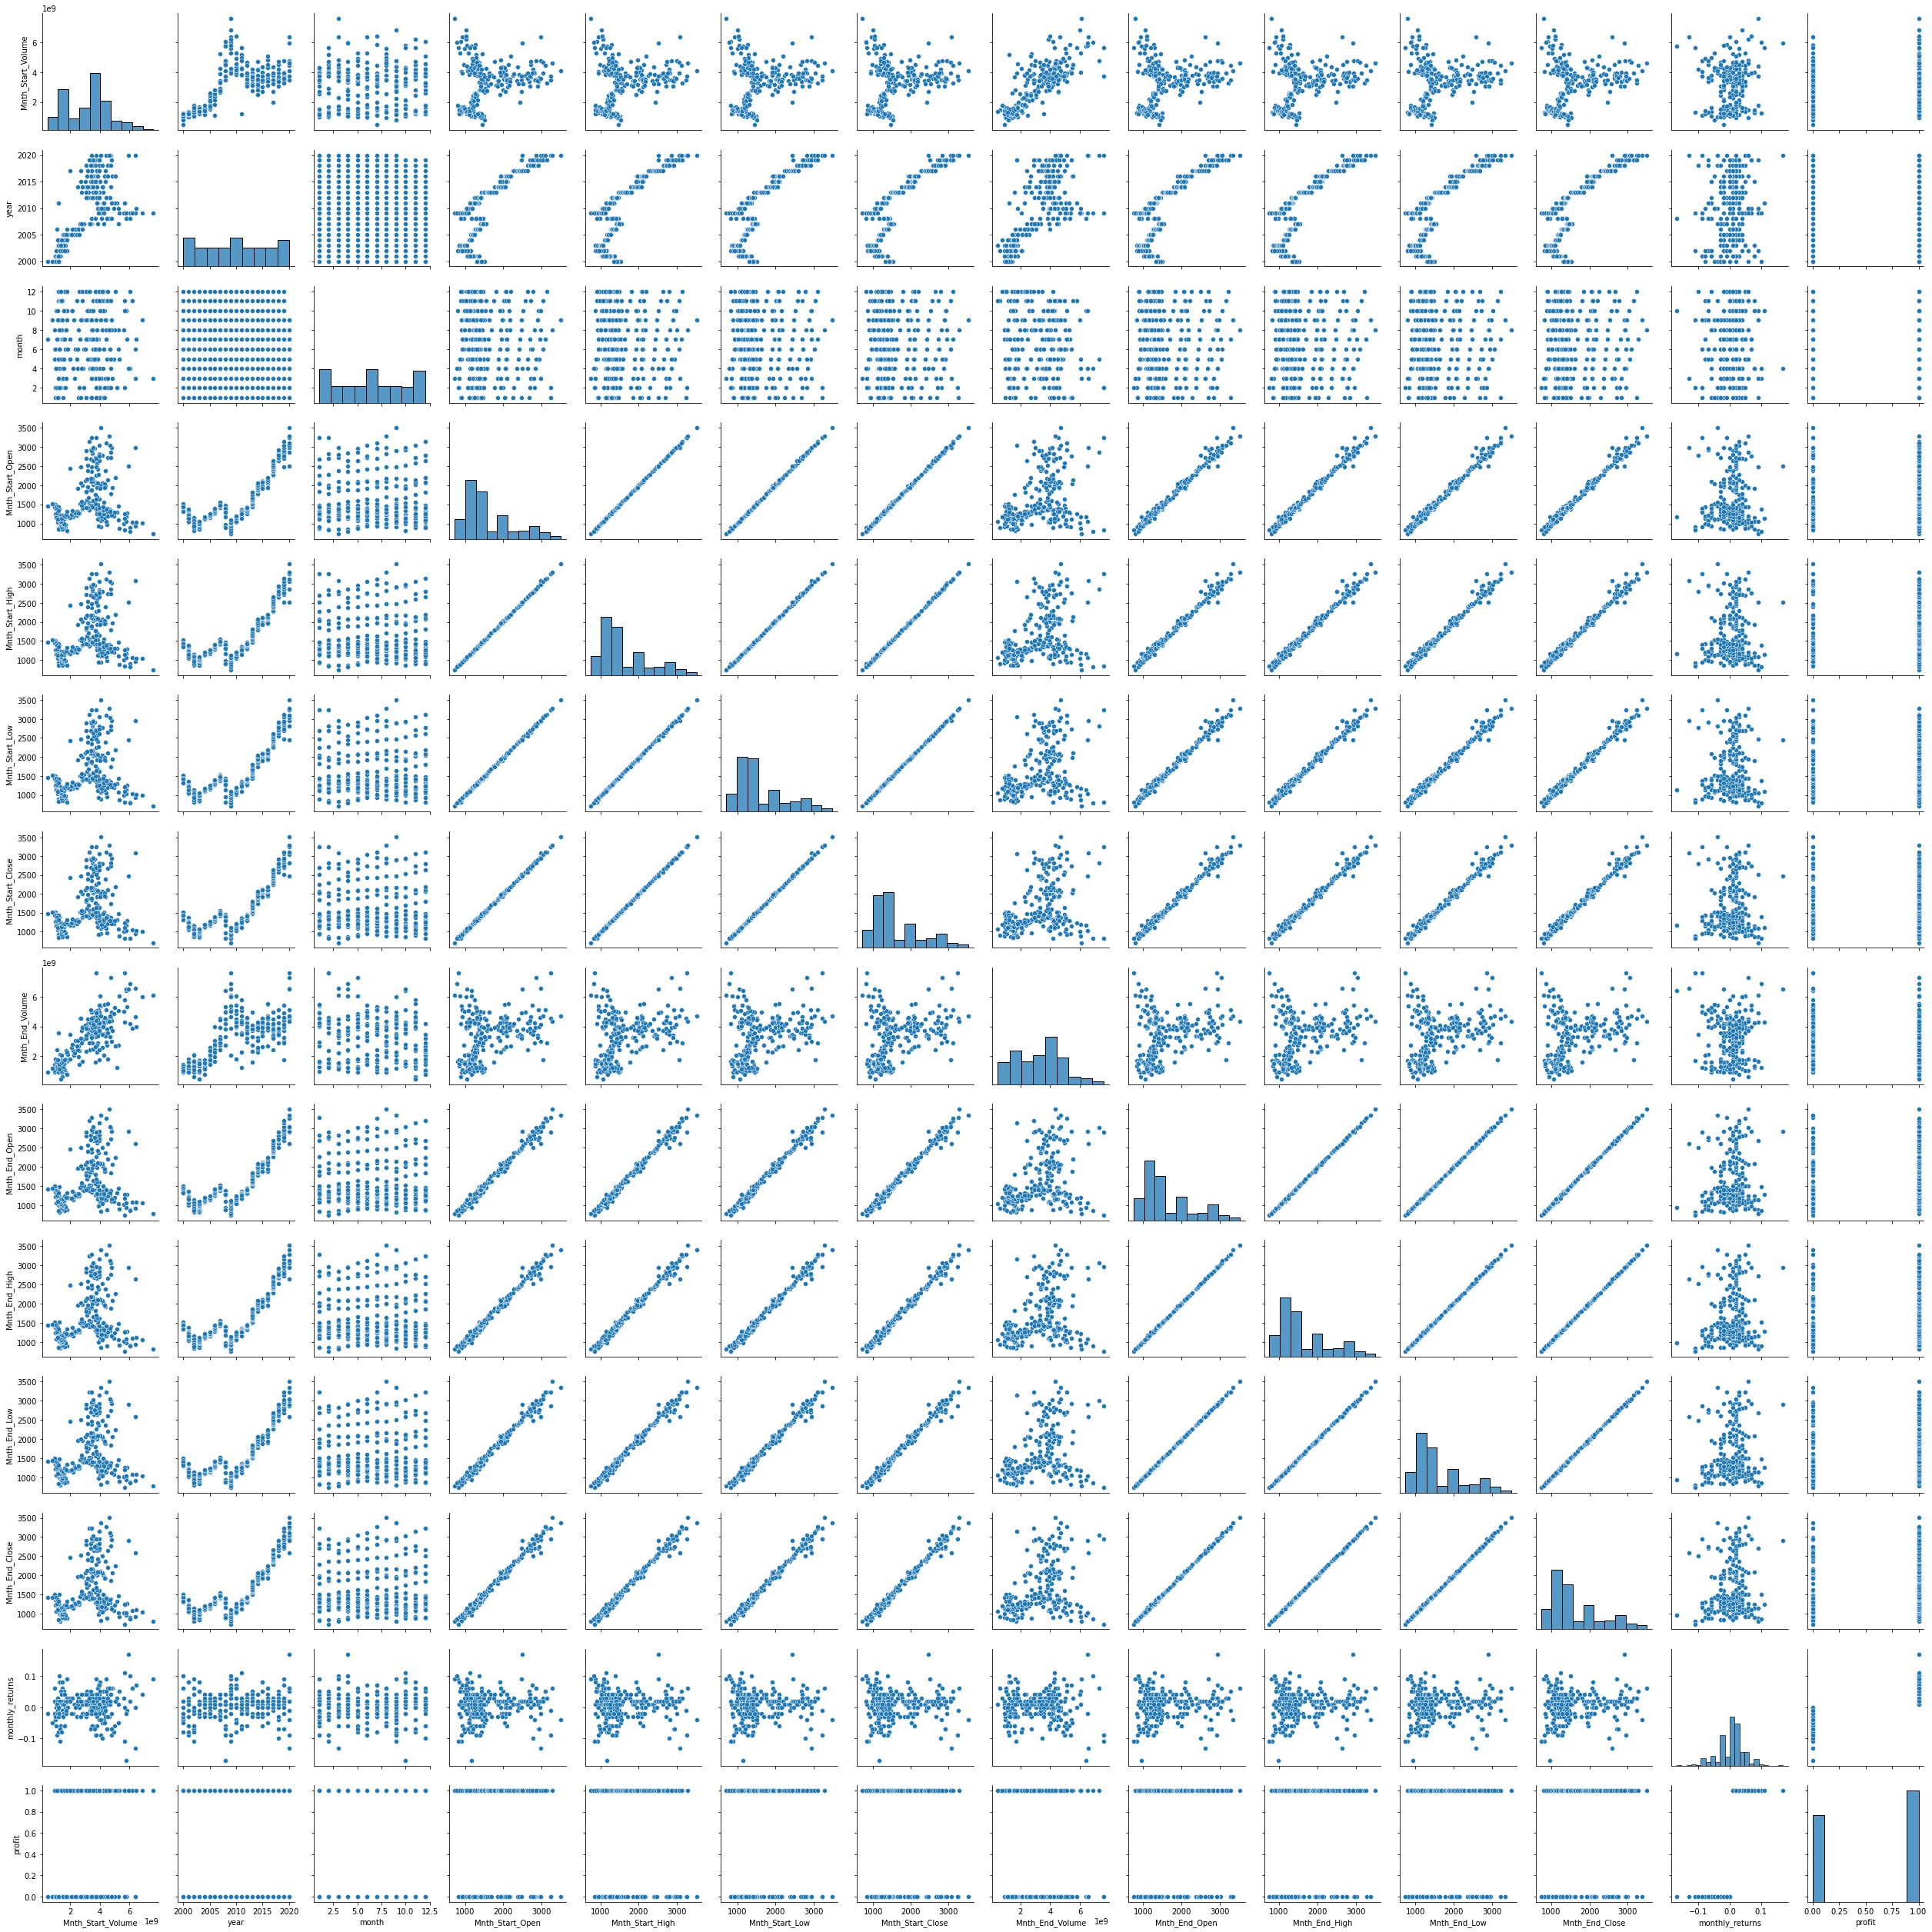

In [172]:
sns.pairplot(monthly_lvl_df)
plt.show()

In [173]:
monthly_df = monthly_lvl_df.drop(columns=['year'])
monthly_df.head()

Mnth_Start_Volume  month  Mnth_Start_Open  Mnth_Start_High  Mnth_Start_Low  \
0         1009000000      1      1455.219971      1455.219971     1397.430054   
1          981000000      2      1394.459961      1412.489990     1384.790039   
2         1274100000      3      1366.420044      1383.459961     1366.420044   
3         1021700000      4      1498.579956      1507.189941     1486.959961   
4          966300000      5      1452.430054      1481.510010     1452.430054   

   Mnth_Start_Close  Mnth_End_Volume  Mnth_End_Open  Mnth_End_High  \
0       1399.420044        993800000    1360.160034    1394.479980   
1       1409.280029       1204300000    1348.050049    1369.630005   
2       1379.189941       1227400000    1487.920044    1519.810059   
3       1505.969971        984600000    1464.920044    1473.619995   
4       1468.250000        960500000    1422.439941    1434.489990   

   Mnth_End_Low  Mnth_End_Close  monthly_returns  profit  
0   1350.140015     1394.459961            -0.04       0  
1   1348.050049     1366.420044            -0.02       0  
2   1484.380005     1498.579956             0.10       1  
3   1448.150024     1452.430054            -0.03       0  
4   1415.500000     1420.599976            -0.02       0

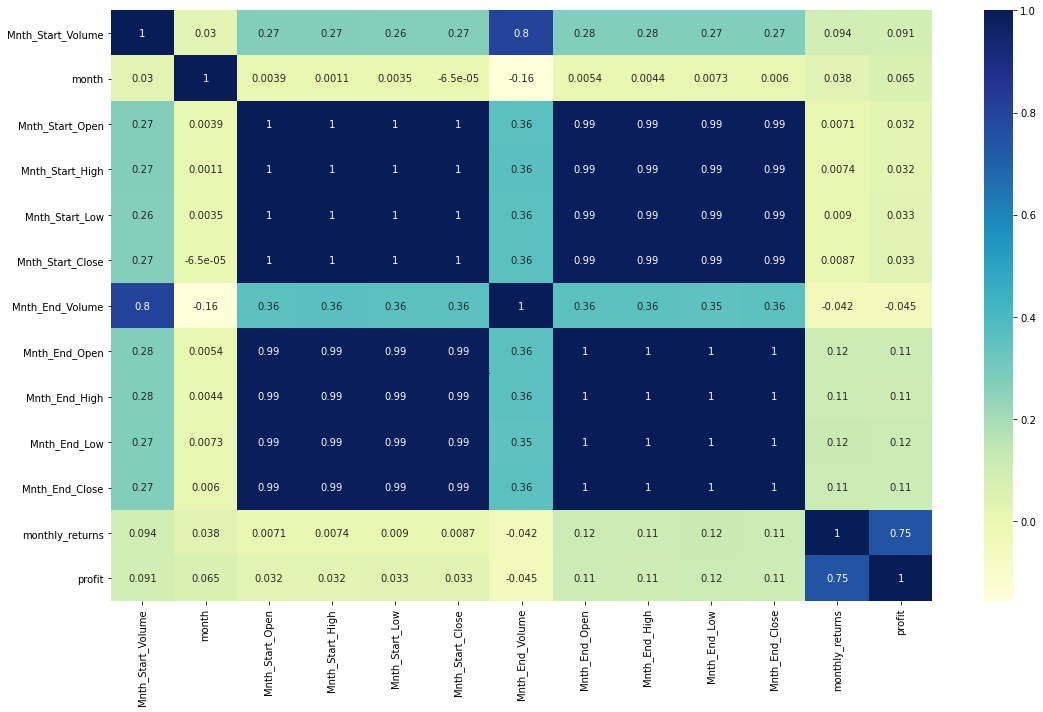

In [174]:
# Let's check the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (16, 10))
sns.heatmap(monthly_df.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [175]:
# multicolinearity
monthly_df = monthly_df.drop(['Mnth_Start_Close','Mnth_Start_Low','Mnth_Start_Open','Mnth_End_Open', 
                             'Mnth_End_High','Mnth_End_Low','Mnth_End_Close'],axis=1)

In [176]:
monthly_df.columns

Index(['Mnth_Start_Volume', 'month', 'Mnth_Start_High', 'Mnth_End_Volume',
       'monthly_returns', 'profit'],
      dtype='object')

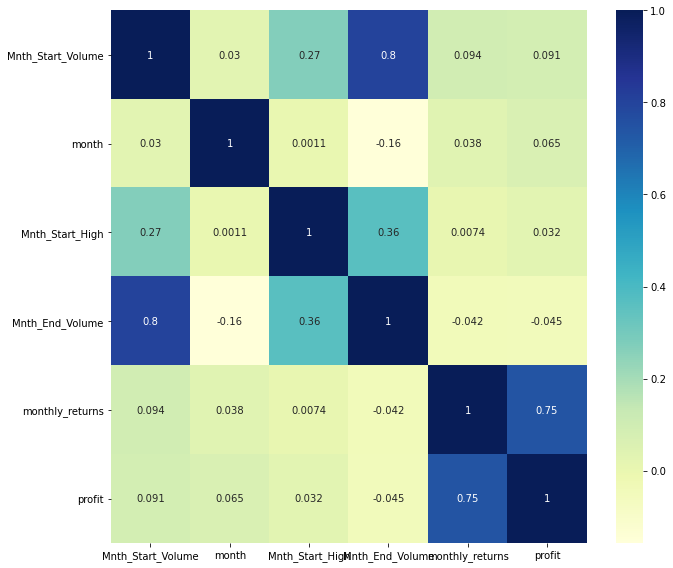

In [177]:
plt.figure(figsize = (10, 8))
sns.heatmap(monthly_df.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [178]:
# Putting feature variable to X
X = monthly_df.drop(['profit','monthly_returns','month'],axis=1)

# Putting response variable to y
y = monthly_df['profit']

In [179]:
X.head()

Mnth_Start_Volume  Mnth_Start_High  Mnth_End_Volume
0         1009000000      1455.219971        993800000
1          981000000      1412.489990       1204300000
2         1274100000      1383.459961       1227400000
3         1021700000      1507.189941        984600000
4          966300000      1481.510010        960500000

In [180]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train.shape, X_test.shape

((174, 3), (75, 3))

In [181]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# X_train[['Mnth_Start_Volume','Mnth_Start_High','Mnth_End_Volume']] = scaler.fit_transform(X_train[['Mnth_Start_Volume','Mnth_Start_High','Mnth_End_Volume']])
# X_train.head()

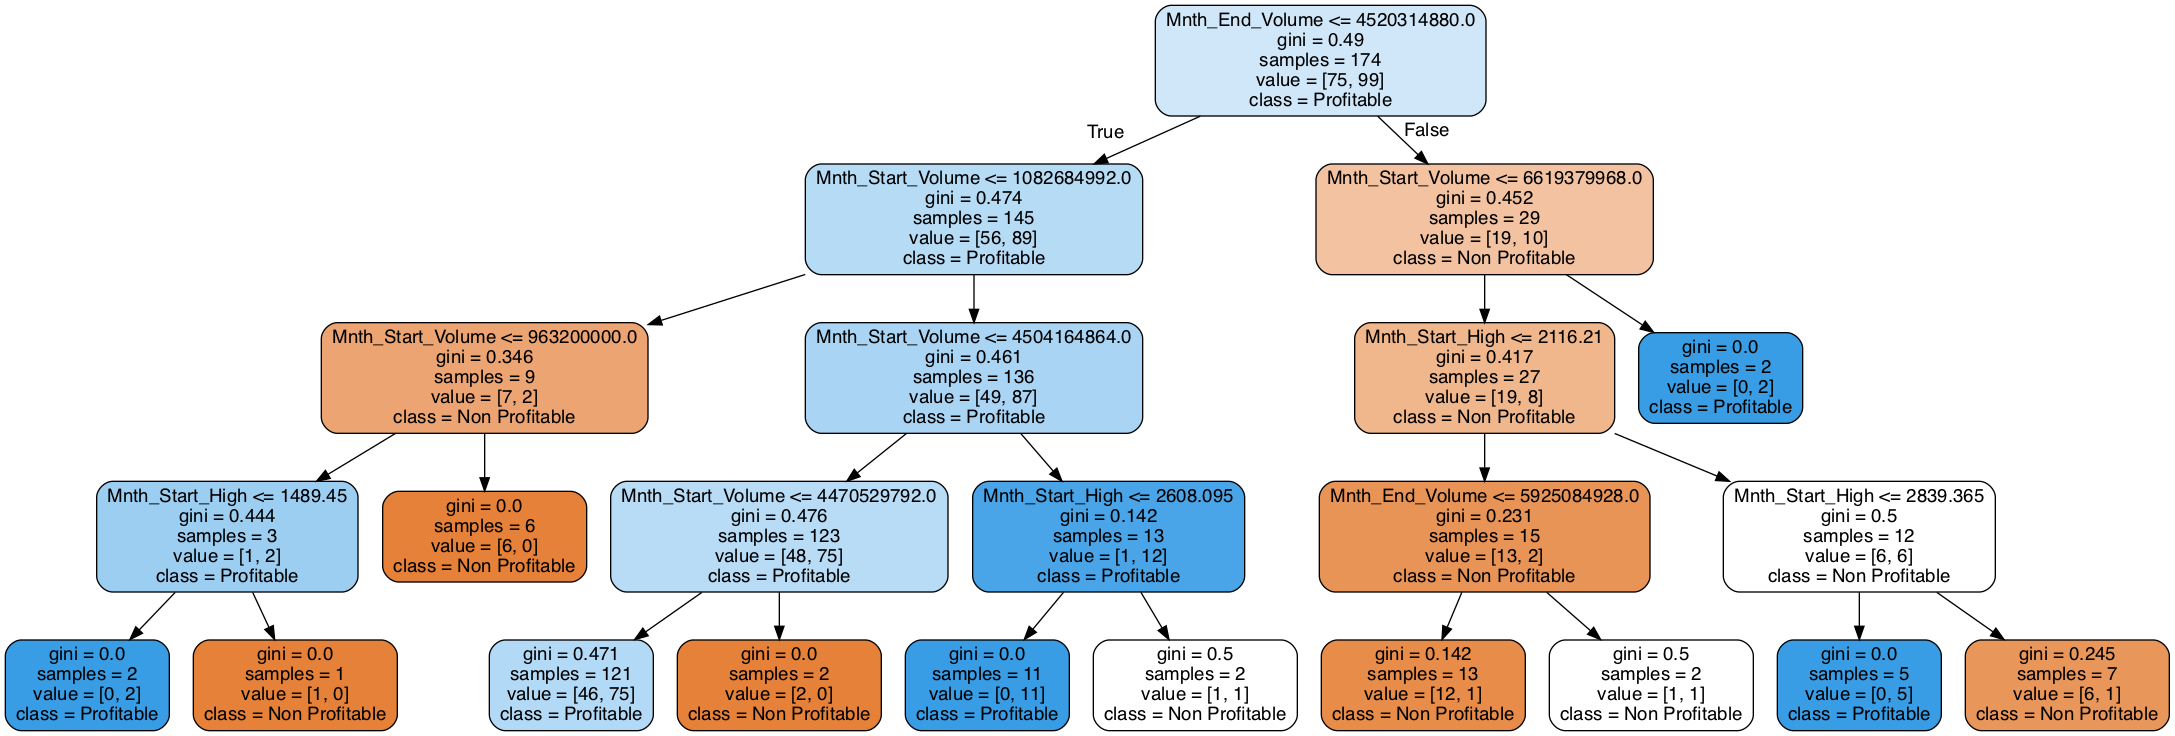

In [183]:
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(X_train, y_train)

#plotting tree with max_depth=3
dot_data = StringIO()  

export_graphviz(dt, out_file=dot_data, filled=True, rounded=True,
                feature_names=X.columns, 
                class_names=['Non Profitable', "Profitable"])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
#Image(graph.create_png(),width=800,height=900)
#graph.write_pdf("dt_heartdisease.pdf")

#### Evaluating model performance

In [184]:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

In [185]:
from sklearn.metrics import confusion_matrix, accuracy_score
print(accuracy_score(y_train, y_train_pred))
confusion_matrix(y_train, y_train_pred)

0.7126436781609196


array([[29, 46],
       [ 4, 95]])

In [186]:
print(accuracy_score(y_test, y_test_pred))
confusion_matrix(y_test, y_test_pred)

0.64


array([[13, 21],
       [ 6, 35]])

In [187]:
# Creating helper functions to evaluate model performance and help plot the decision tree
def get_dt_graph(dt_classifier):
    dot_data = StringIO()
    export_graphviz(dt_classifier, out_file=dot_data, filled=True,rounded=True,
                    feature_names=X.columns, 
                    class_names=['Non Profitable', "Profitable"])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph

In [188]:
def evaluate_model(dt_classifier):
    print("Train Accuracy :", accuracy_score(y_train, dt_classifier.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, dt_classifier.predict(X_train)))
    
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, dt_classifier.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, dt_classifier.predict(X_test)))

#### Hyperparameter tunning

In [189]:
dt = DecisionTreeClassifier(random_state=42)
from sklearn.model_selection import GridSearchCV

In [190]:
# Creating the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [2, 3, 4, 5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [191]:
# Instantiating the grid search model
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [192]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 80 candidates, totalling 320 fits
CPU times: user 331 ms, sys: 165 ms, total: 497 ms
Wall time: 3.44 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [2, 3, 4, 5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [193]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.005546      0.000390         0.003131        0.000109   
1       0.005494      0.000221         0.004602        0.001705   
2       0.005326      0.000031         0.003196        0.000248   
3       0.008447      0.000939         0.004946        0.000400   
4       0.008116      0.000670         0.004157        0.000481   

  param_criterion param_max_depth param_min_samples_leaf  \
0            gini               2                      2   
1            gini               2                      3   
2            gini               2                      4   
3            gini               2                      5   
4            gini               2                     10   

                                              params  split0_test_score  \
0  {'criterion': 'gini', 'max_depth': 2, 'min_sam...           0.454545   
1  {'criterion': 'gini', 'max_depth': 2, 'min_sam...           0.454545   
2  {'criterion': 'gini', 'max_depth': 2, 'min_sam...           0.454545   
3  {'criterion': 'gini', 'max_depth': 2, 'min_sam...           0.454545   
4  {'criterion': 'gini', 'max_depth': 2, 'min_sam...           0.431818   

   split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
0           0.636364           0.534884           0.534884         0.540169   
1           0.636364           0.534884           0.534884         0.540169   
2           0.636364           0.534884           0.534884         0.540169   
3           0.636364           0.534884           0.534884         0.540169   
4           0.636364           0.581395           0.581395         0.557743   

   std_test_score  rank_test_score  
0        0.064499               56  
1        0.064499               56  
2        0.064499               56  
3        0.064499               56  
4        0.076087               46

In [194]:
score_df.nlargest(5,"mean_test_score")

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
24       0.003101      0.000527         0.002085        0.000613   
16       0.002865      0.000180         0.001696        0.000068   
13       0.002861      0.000119         0.001850        0.000200   
21       0.003028      0.000528         0.001722        0.000359   
29       0.003152      0.000858         0.001653        0.000346   

   param_criterion param_max_depth param_min_samples_leaf  \
24            gini              10                      2   
16            gini               5                      2   
13            gini               3                     20   
21            gini               5                     20   
29            gini              10                     20   

                                               params  split0_test_score  \
24  {'criterion': 'gini', 'max_depth': 10, 'min_sa...           0.500000   
16  {'criterion': 'gini', 'max_depth': 5, 'min_sam...           0.500000   
13  {'criterion': 'gini', 'max_depth': 3, 'min_sam...           0.568182   
21  {'criterion': 'gini', 'max_depth': 5, 'min_sam...           0.568182   
29  {'criterion': 'gini', 'max_depth': 10, 'min_sa...           0.568182   

    split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
24           0.590909           0.674419           0.651163         0.604123   
16           0.659091           0.627907           0.627907         0.603726   
13           0.613636           0.604651           0.581395         0.591966   
21           0.613636           0.604651           0.581395         0.591966   
29           0.613636           0.604651           0.581395         0.591966   

    std_test_score  rank_test_score  
24        0.067399                1  
16        0.061225                2  
13        0.018083                3  
21        0.018083                3  
29        0.018083                3

In [195]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, random_state=42)

In [196]:
grid_search.best_score_

0.6041226215644819

In [197]:
dt_best = grid_search.best_estimator_
evaluate_model(dt_best)

Train Accuracy : 0.764367816091954
Train Confusion Matrix:
[[38 37]
 [ 4 95]]
--------------------------------------------------
Test Accuracy : 0.6533333333333333
Test Confusion Matrix:
[[16 18]
 [ 8 33]]


In [198]:
from sklearn.metrics import classification_report
print(classification_report(y_test, dt_best.predict(X_test)))

              precision    recall  f1-score   support

           0       0.67      0.47      0.55        34
           1       0.65      0.80      0.72        41

    accuracy                           0.65        75
   macro avg       0.66      0.64      0.63        75
weighted avg       0.66      0.65      0.64        75



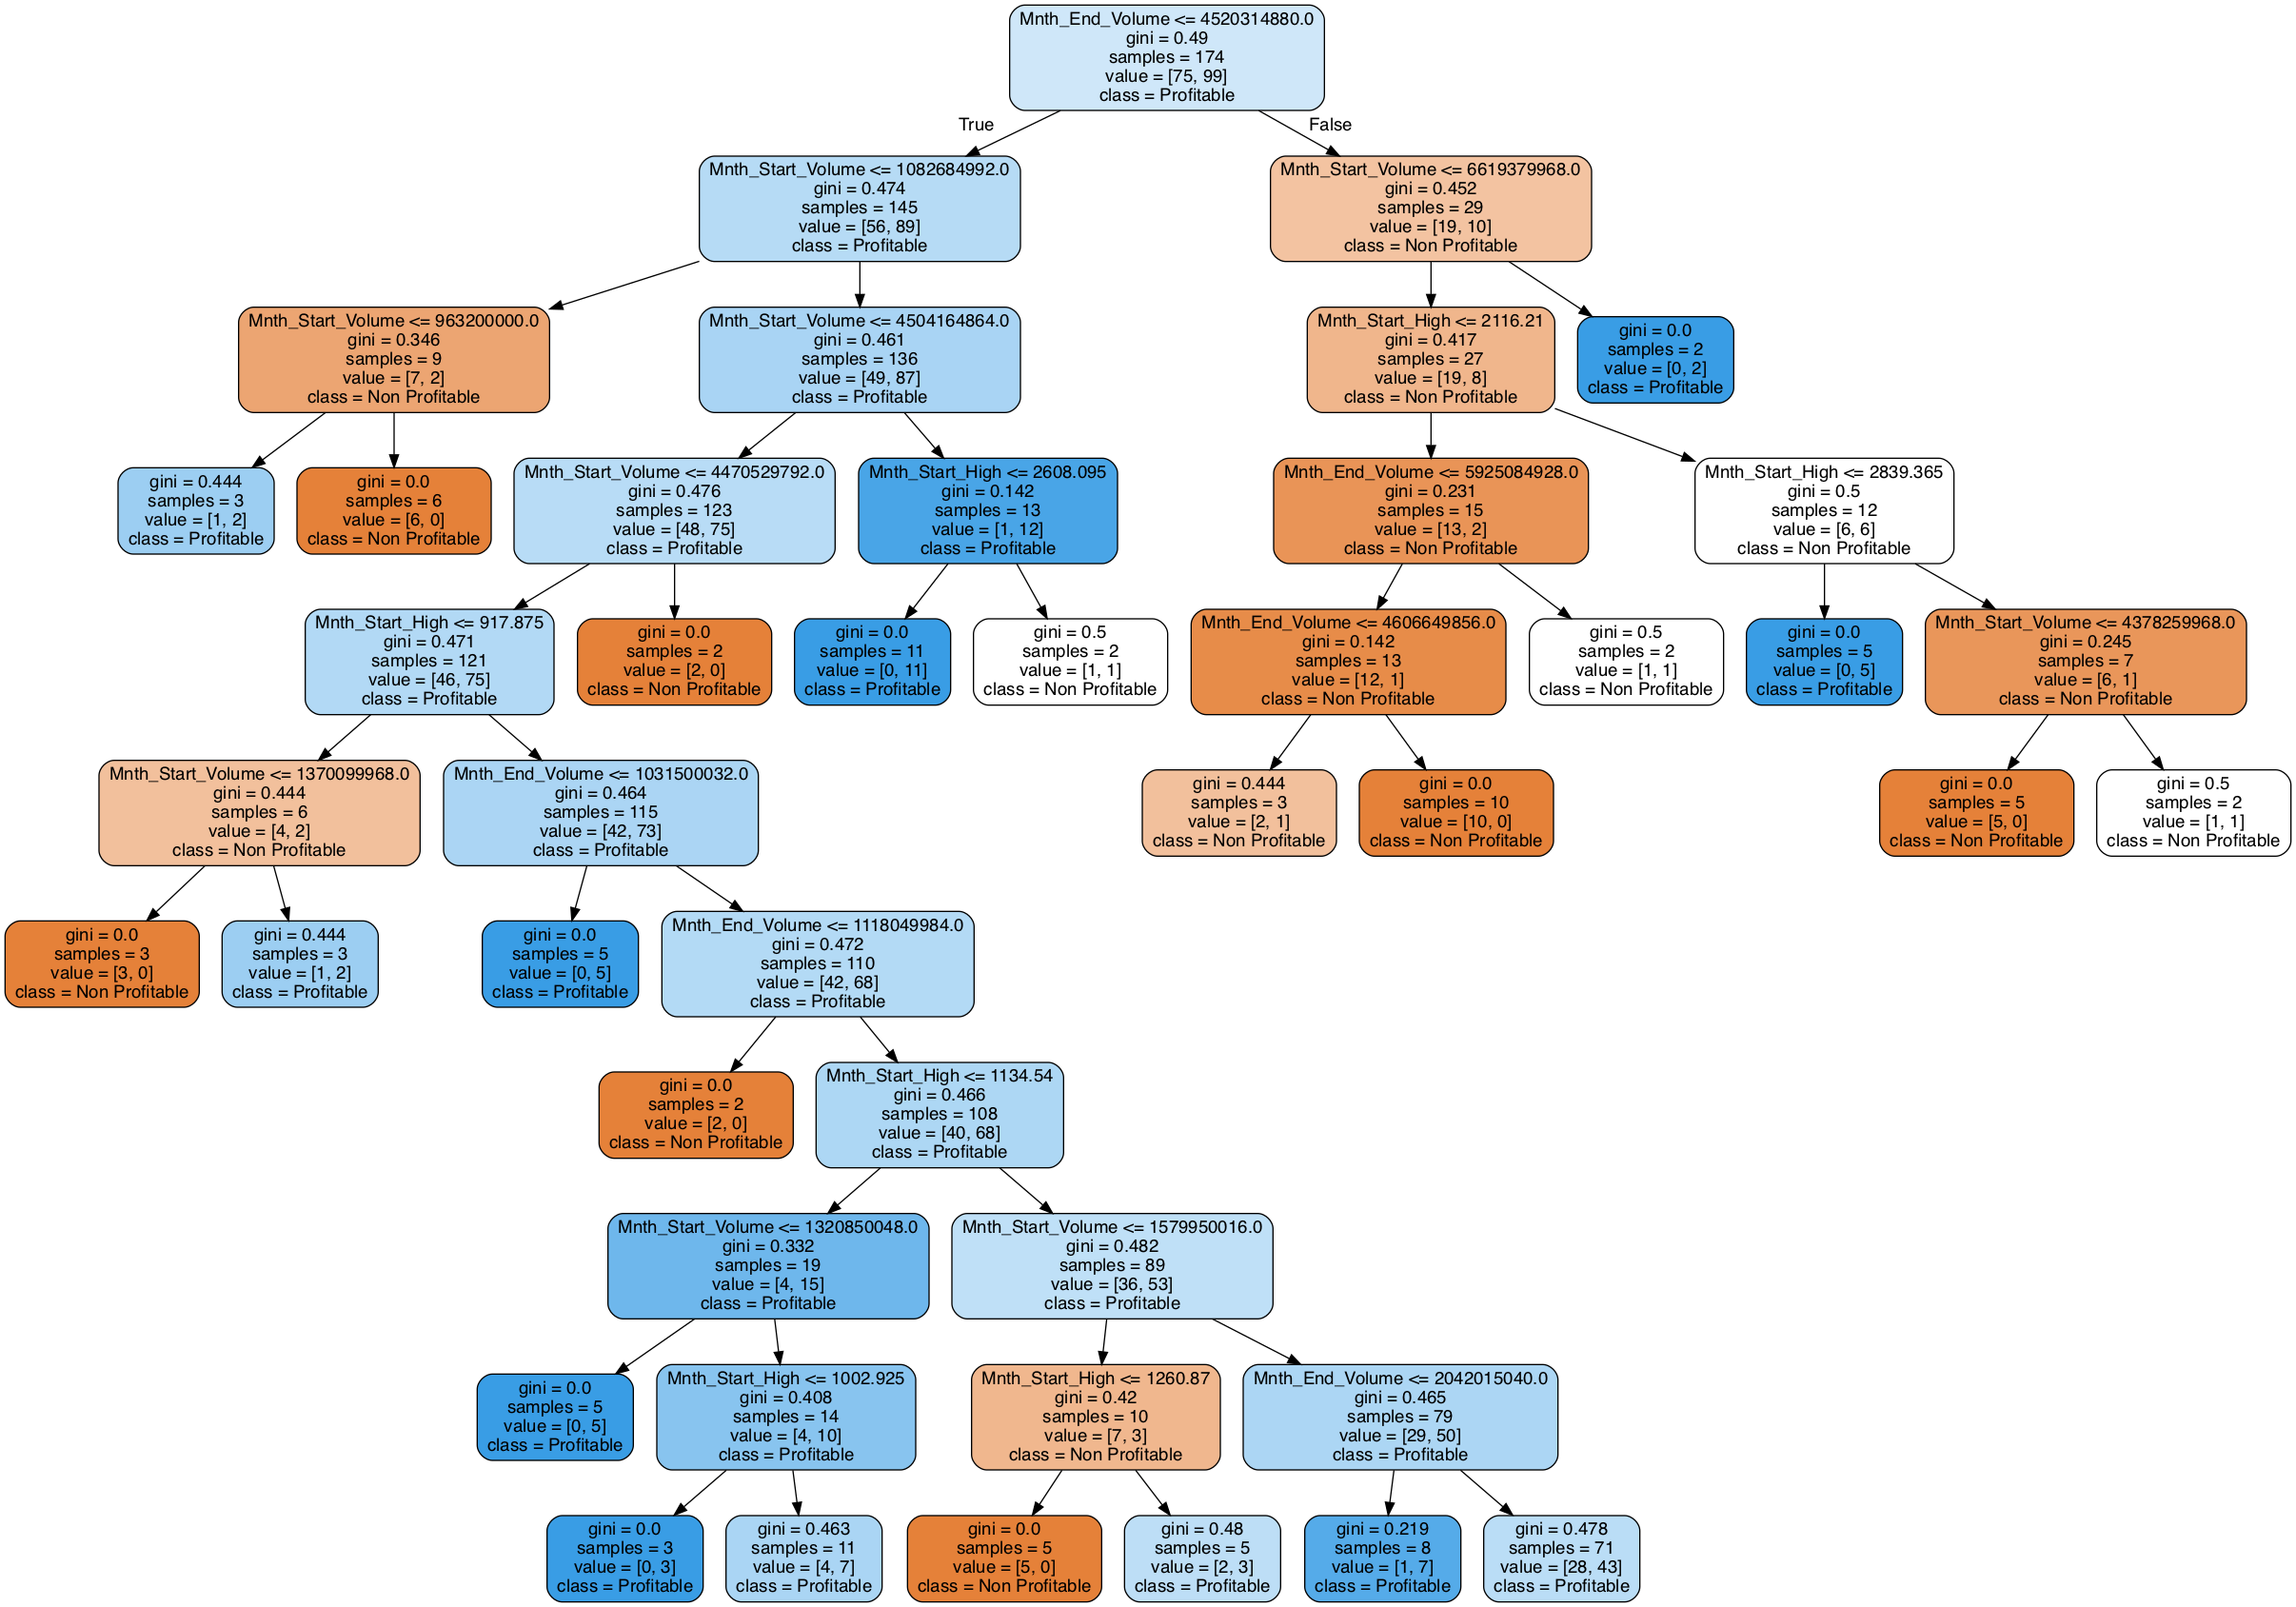

In [199]:
gph = get_dt_graph(dt_best)
Image(gph.create_png())

#### Method 2 - Decision Tree 

In [200]:
monthly_df.columns

Index(['Mnth_Start_Volume', 'month', 'Mnth_Start_High', 'Mnth_End_Volume',
       'monthly_returns', 'profit'],
      dtype='object')

In [201]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.
dummy1 = pd.get_dummies(monthly_df['month'], drop_first=False,prefix='month')

# Adding the results to the master dataframe
monthly_df1 = pd.concat([monthly_df, dummy1], axis=1)
monthly_df1.head()

Mnth_Start_Volume  month  Mnth_Start_High  Mnth_End_Volume  \
0         1009000000      1      1455.219971        993800000   
1          981000000      2      1412.489990       1204300000   
2         1274100000      3      1383.459961       1227400000   
3         1021700000      4      1507.189941        984600000   
4          966300000      5      1481.510010        960500000   

   monthly_returns  profit  month_1  month_2  month_3  month_4  month_5  \
0            -0.04       0        1        0        0        0        0   
1            -0.02       0        0        1        0        0        0   
2             0.10       1        0        0        1        0        0   
3            -0.03       0        0        0        0        1        0   
4            -0.02       0        0        0        0        0        1   

   month_6  month_7  month_8  month_9  month_10  month_11  month_12  
0        0        0        0        0         0         0         0  
1        0        0        0        0         0         0         0  
2        0        0        0        0         0         0         0  
3        0        0        0        0         0         0         0  
4        0        0        0        0         0         0         0

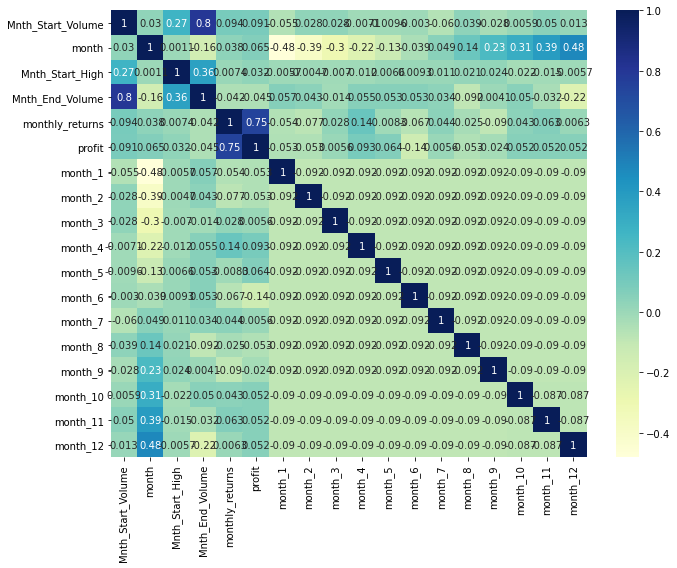

In [202]:
plt.figure(figsize = (10, 8))
sns.heatmap(monthly_df1.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [203]:
# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%
monthly_df1.describe(percentiles=[.25, .5, .75, .90, .95, .99])

Mnth_Start_Volume       month  Mnth_Start_High  Mnth_End_Volume  \
count       2.490000e+02  249.000000       249.000000     2.490000e+02   
mean        3.191577e+09    6.445783      1637.321561     3.260821e+09   
std         1.439058e+09    3.442803       641.783039     1.519517e+09   
min         4.519000e+08    1.000000       729.570007     4.872200e+08   
25%         1.681980e+09    3.000000      1162.869995     1.788510e+09   
50%         3.429160e+09    6.000000      1399.619995     3.442870e+09   
75%         4.083110e+09    9.000000      2067.629883     4.284160e+09   
90%         4.781040e+09   11.000000      2732.097901     5.038102e+09   
95%         5.672098e+09   12.000000      2947.301953     5.694738e+09   
99%         6.407272e+09   12.000000      3263.495918     7.077061e+09   
max         7.607433e+09   12.000000      3528.030029     7.607433e+09   

       monthly_returns      profit     month_1     month_2     month_3  \
count       249.000000  249.000000  249.000000  249.000000  249.000000   
mean          0.004056    0.562249    0.084337    0.084337    0.084337   
std           0.044168    0.497109    0.278453    0.278453    0.278453   
min          -0.170000    0.000000    0.000000    0.000000    0.000000   
25%          -0.020000    0.000000    0.000000    0.000000    0.000000   
50%           0.010000    1.000000    0.000000    0.000000    0.000000   
75%           0.030000    1.000000    0.000000    0.000000    0.000000   
90%           0.050000    1.000000    0.000000    0.000000    0.000000   
95%           0.070000    1.000000    1.000000    1.000000    1.000000   
99%           0.100000    1.000000    1.000000    1.000000    1.000000   
max           0.170000    1.000000    1.000000    1.000000    1.000000   

          month_4     month_5     month_6     month_7     month_8     month_9  \
count  249.000000  249.000000  249.000000  249.000000  249.000000  249.000000   
mean     0.084337    0.084337    0.084337    0.084337    0.084337    0.084337   
std      0.278453    0.278453    0.278453    0.278453    0.278453    0.278453   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
90%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
95%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
99%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

         month_10    month_11    month_12  
count  249.000000  249.000000  249.000000  
mean     0.080321    0.080321    0.080321  
std      0.272337    0.272337    0.272337  
min      0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000  
50%      0.000000    0.000000    0.000000  
75%      0.000000    0.000000    0.000000  
90%      0.000000    0.000000    0.000000  
95%      1.000000    1.000000    1.000000  
99%      1.000000    1.000000    1.000000  
max      1.000000    1.000000    1.000000

From the distribution shown above, we can see that there are no outliers in the data. The numbers are gradually increasing.

In [204]:
# Putting feature variable to X
X = monthly_df1.drop(['profit','monthly_returns','month'],axis=1)

# Putting response variable to y
y = monthly_df1['profit']

In [205]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train.shape, X_test.shape

((174, 15), (75, 15))

In [206]:
X_train.head()

Mnth_Start_Volume  Mnth_Start_High  Mnth_End_Volume  month_1  month_2  \
82          2821160000      1381.949951       4006230000        0        0   
29          1324300000      1070.739990       2117000000        0        0   
126         6435770000      1033.579956       4006450000        0        0   
79          2527690000      1278.660034       1974540000        0        0   
86          3874910000      1409.459961       2903960000        0        0   

     month_3  month_4  month_5  month_6  month_7  month_8  month_9  month_10  \
82         0        0        0        0        0        0        0         0   
29         0        0        0        1        0        0        0         0   
126        0        0        0        0        1        0        0         0   
79         0        0        0        0        0        1        0         0   
86         1        0        0        0        0        0        0         0   

     month_11  month_12  
82          1         0  
29          0         0  
126         0         0  
79          0         0  
86          0         0

In [207]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 80 candidates, totalling 320 fits
CPU times: user 282 ms, sys: 21.3 ms, total: 303 ms
Wall time: 357 ms


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [2, 3, 4, 5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [209]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.002965      0.000132         0.001720        0.000004   
1       0.002994      0.000071         0.001789        0.000033   
2       0.002898      0.000069         0.001832        0.000241   
3       0.003275      0.000409         0.002283        0.000308   
4       0.003927      0.000654         0.002451        0.000410   

  param_criterion param_max_depth param_min_samples_leaf  \
0            gini               2                      2   
1            gini               2                      3   
2            gini               2                      4   
3            gini               2                      5   
4            gini               2                     10   

                                              params  split0_test_score  \
0  {'criterion': 'gini', 'max_depth': 2, 'min_sam...           0.454545   
1  {'criterion': 'gini', 'max_depth': 2, 'min_sam...           0.454545   
2  {'criterion': 'gini', 'max_depth': 2, 'min_sam...           0.454545   
3  {'criterion': 'gini', 'max_depth': 2, 'min_sam...           0.454545   
4  {'criterion': 'gini', 'max_depth': 2, 'min_sam...           0.431818   

   split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
0           0.636364           0.581395           0.581395         0.563425   
1           0.636364           0.581395           0.534884         0.551797   
2           0.636364           0.581395           0.534884         0.551797   
3           0.636364           0.581395           0.534884         0.551797   
4           0.636364           0.581395           0.581395         0.557743   

   std_test_score  rank_test_score  
0        0.066747               29  
1        0.066655               47  
2        0.066655               47  
3        0.066655               47  
4        0.076087               37

In [210]:
score_df.nlargest(5,"mean_test_score")

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
9        0.004925      0.000288         0.002500        0.000499   
13       0.005685      0.000287         0.003620        0.000154   
21       0.004987      0.000220         0.002686        0.000375   
29       0.004655      0.000152         0.002895        0.000233   
37       0.004422      0.000161         0.002593        0.000172   

   param_criterion param_max_depth param_min_samples_leaf  \
9             gini               3                      3   
13            gini               3                     20   
21            gini               5                     20   
29            gini              10                     20   
37            gini              20                     20   

                                               params  split0_test_score  \
9   {'criterion': 'gini', 'max_depth': 3, 'min_sam...           0.545455   
13  {'criterion': 'gini', 'max_depth': 3, 'min_sam...           0.568182   
21  {'criterion': 'gini', 'max_depth': 5, 'min_sam...           0.568182   
29  {'criterion': 'gini', 'max_depth': 10, 'min_sa...           0.568182   
37  {'criterion': 'gini', 'max_depth': 20, 'min_sa...           0.568182   

    split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
9            0.613636           0.604651           0.604651         0.592098   
13           0.613636           0.604651           0.581395         0.591966   
21           0.613636           0.604651           0.581395         0.591966   
29           0.613636           0.604651           0.581395         0.591966   
37           0.613636           0.604651           0.581395         0.591966   

    std_test_score  rank_test_score  
9         0.027178                1  
13        0.018083                2  
21        0.018083                2  
29        0.018083                2  
37        0.018083                2

In [211]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=3, min_samples_leaf=3, random_state=42)

In [212]:
grid_search.best_score_

0.5920983086680761

In [213]:
dt_best = grid_search.best_estimator_
evaluate_model(dt_best)

Train Accuracy : 0.7011494252873564
Train Confusion Matrix:
[[29 46]
 [ 6 93]]
--------------------------------------------------
Test Accuracy : 0.6666666666666666
Test Confusion Matrix:
[[14 20]
 [ 5 36]]


In [214]:
from sklearn.metrics import classification_report
print(classification_report(y_test, dt_best.predict(X_test)))

              precision    recall  f1-score   support

           0       0.74      0.41      0.53        34
           1       0.64      0.88      0.74        41

    accuracy                           0.67        75
   macro avg       0.69      0.64      0.64        75
weighted avg       0.69      0.67      0.65        75



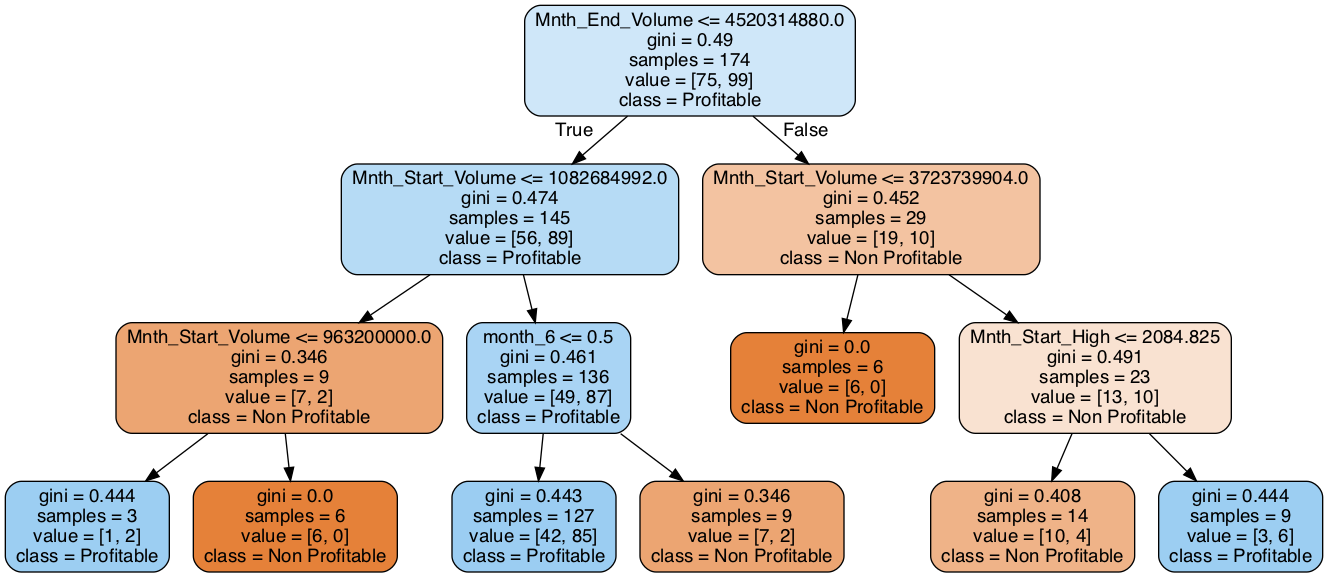

In [215]:
gph = get_dt_graph(dt_best)
Image(gph.create_png())






# 

# 

# 

#     

#### Method 3  - DT on daily data

In [368]:
market_param_da.head()

Date      Volume  cluster_id  year  month  day  weekday         Open  \
0  2000-01-04  1009000000           1  2000      1    4        1  1455.219971   
1  2000-01-05  1085500000           1  2000      1    5        2  1399.420044   
2  2000-01-06  1092300000           1  2000      1    6        3  1402.109985   
3  2000-01-07  1225200000           1  2000      1    7        4  1403.449951   
4  2000-01-10  1064800000           1  2000      1   10        0  1441.469971   

          High          Low        Close    Adj Close  Parameter1  Parameter2  \
0  1455.219971  1397.430054  1399.420044  1399.420044       -0.01        0.04   
1  1413.270020  1377.680054  1402.109985  1402.109985       -0.04       -0.00   
2  1411.900024  1392.099976  1403.449951  1403.449951        0.00       -0.00   
3  1441.469971  1400.729980  1441.469971  1441.469971        0.00       -0.03   
4  1464.359985  1441.469971  1457.599976  1457.599976        0.03       -0.01   

   Parameter3  
0        0.08  
1        0.08  
2        0.01  
3        0.12  
4       -0.13

In [370]:
# daily returns i.e., fractional difference between the month’s closing price and opening price
daily_df = market_param_da.copy(deep=False)
daily_df['Daily_return']=round((daily_df['Close'] - daily_df['Open'])/abs(daily_df['Open']),2)
daily_df.head()

Date      Volume  cluster_id  year  month  day  weekday         Open  \
0  2000-01-04  1009000000           1  2000      1    4        1  1455.219971   
1  2000-01-05  1085500000           1  2000      1    5        2  1399.420044   
2  2000-01-06  1092300000           1  2000      1    6        3  1402.109985   
3  2000-01-07  1225200000           1  2000      1    7        4  1403.449951   
4  2000-01-10  1064800000           1  2000      1   10        0  1441.469971   

          High          Low        Close    Adj Close  Parameter1  Parameter2  \
0  1455.219971  1397.430054  1399.420044  1399.420044       -0.01        0.04   
1  1413.270020  1377.680054  1402.109985  1402.109985       -0.04       -0.00   
2  1411.900024  1392.099976  1403.449951  1403.449951        0.00       -0.00   
3  1441.469971  1400.729980  1441.469971  1441.469971        0.00       -0.03   
4  1464.359985  1441.469971  1457.599976  1457.599976        0.03       -0.01   

   Parameter3  Daily_return  
0        0.08         -0.04  
1        0.08          0.00  
2        0.01          0.00  
3        0.12          0.03  
4       -0.13          0.01

In [371]:
daily_df['profit'] = np.where((daily_df['Daily_return']>0),1,0)
daily_df.head()

Date      Volume  cluster_id  year  month  day  weekday         Open  \
0  2000-01-04  1009000000           1  2000      1    4        1  1455.219971   
1  2000-01-05  1085500000           1  2000      1    5        2  1399.420044   
2  2000-01-06  1092300000           1  2000      1    6        3  1402.109985   
3  2000-01-07  1225200000           1  2000      1    7        4  1403.449951   
4  2000-01-10  1064800000           1  2000      1   10        0  1441.469971   

          High          Low        Close    Adj Close  Parameter1  Parameter2  \
0  1455.219971  1397.430054  1399.420044  1399.420044       -0.01        0.04   
1  1413.270020  1377.680054  1402.109985  1402.109985       -0.04       -0.00   
2  1411.900024  1392.099976  1403.449951  1403.449951        0.00       -0.00   
3  1441.469971  1400.729980  1441.469971  1441.469971        0.00       -0.03   
4  1464.359985  1441.469971  1457.599976  1457.599976        0.03       -0.01   

   Parameter3  Daily_return  profit  
0        0.08         -0.04       0  
1        0.08          0.00       0  
2        0.01          0.00       0  
3        0.12          0.03       1  
4       -0.13          0.01       1

In [372]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.
dummy1 = pd.get_dummies(daily_df['month'], drop_first=False,prefix='month')
dummy1.head()

month_1  month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
0        1        0        0        0        0        0        0        0   
1        1        0        0        0        0        0        0        0   
2        1        0        0        0        0        0        0        0   
3        1        0        0        0        0        0        0        0   
4        1        0        0        0        0        0        0        0   

   month_9  month_10  month_11  month_12  
0        0         0         0         0  
1        0         0         0         0  
2        0         0         0         0  
3        0         0         0         0  
4        0         0         0         0

In [373]:
dummy2 = pd.get_dummies(daily_df['weekday'], drop_first=False,prefix='weekday')
dummy2.head()

weekday_0  weekday_1  weekday_2  weekday_3  weekday_4
0          0          1          0          0          0
1          0          0          1          0          0
2          0          0          0          1          0
3          0          0          0          0          1
4          1          0          0          0          0

In [374]:
# Adding the results to the master dataframe
daily_df1 = pd.concat([daily_df, dummy1, dummy2], axis=1)
daily_df1.head()

Date      Volume  cluster_id  year  month  day  weekday         Open  \
0  2000-01-04  1009000000           1  2000      1    4        1  1455.219971   
1  2000-01-05  1085500000           1  2000      1    5        2  1399.420044   
2  2000-01-06  1092300000           1  2000      1    6        3  1402.109985   
3  2000-01-07  1225200000           1  2000      1    7        4  1403.449951   
4  2000-01-10  1064800000           1  2000      1   10        0  1441.469971   

          High          Low  ...  month_8  month_9  month_10  month_11  \
0  1455.219971  1397.430054  ...        0        0         0         0   
1  1413.270020  1377.680054  ...        0        0         0         0   
2  1411.900024  1392.099976  ...        0        0         0         0   
3  1441.469971  1400.729980  ...        0        0         0         0   
4  1464.359985  1441.469971  ...        0        0         0         0   

   month_12  weekday_0  weekday_1  weekday_2  weekday_3  weekday_4  
0         0          0          1          0          0          0  
1         0          0          0          1          0          0  
2         0          0          0          0          1          0  
3         0          0          0          0          0          1  
4         0          1          0          0          0          0  

[5 rows x 34 columns]

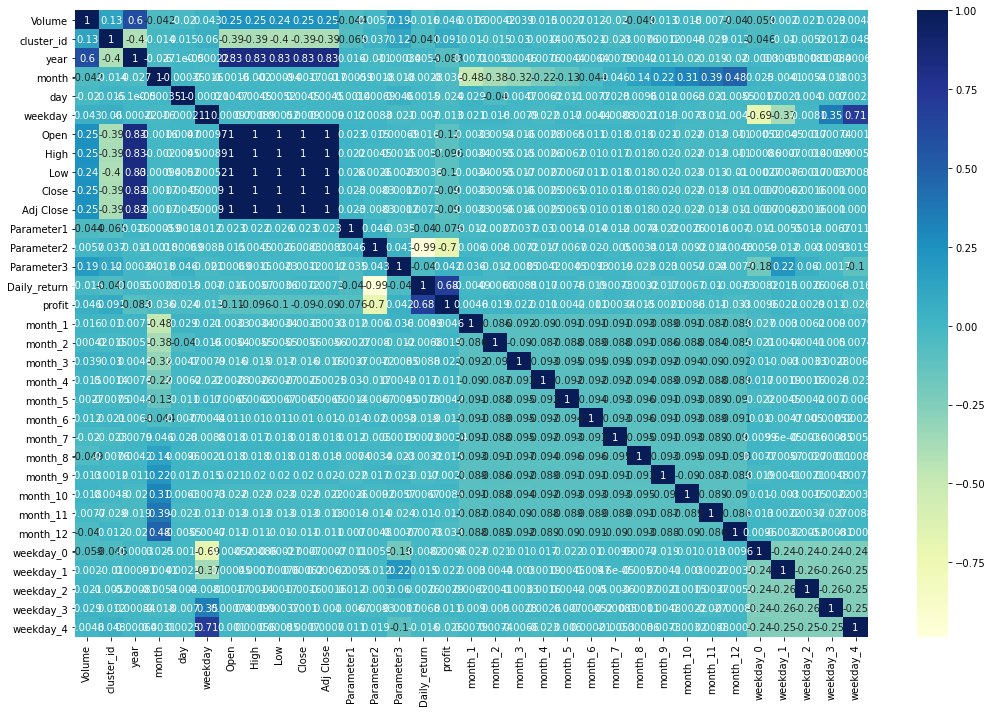

In [375]:
plt.figure(figsize = (15, 10))
sns.heatmap(daily_df1.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [376]:
# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%
daily_df1.describe(percentiles=[.25, .5, .75, .90, .95, .99])

Volume   cluster_id         year        month          day  \
count  5.219000e+03  5219.000000  5219.000000  5219.000000  5219.000000   
mean   3.154662e+09     0.609504  2009.885419     6.487833    15.749760   
std    1.485934e+09     0.712126     5.988130     3.409903     8.753242   
min    3.560700e+08     0.000000  2000.000000     1.000000     1.000000   
25%    1.722910e+09     0.000000  2005.000000     4.000000     8.000000   
50%    3.267960e+09     0.000000  2010.000000     6.000000    16.000000   
75%    3.990670e+09     1.000000  2015.000000     9.000000    23.000000   
90%    4.996444e+09     2.000000  2018.000000    11.000000    28.000000   
95%    5.804643e+09     2.000000  2019.000000    12.000000    29.100000   
99%    7.606223e+09     2.000000  2020.000000    12.000000    31.000000   
max    7.607433e+09     2.000000  2020.000000    12.000000    31.000000   

           weekday         Open         High          Low        Close  ...  \
count  5219.000000  5219.000000  5219.000000  5219.000000  5219.000000  ...   
mean      2.022418  1630.227572  1639.715216  1619.874831  1630.397773  ...   
std       1.399938   644.453739   646.298333   642.221539   644.509389  ...   
min       0.000000   679.280029   695.270020   666.789978   676.530029  ...   
25%       1.000000  1160.864990  1168.820007  1150.984985  1160.885010  ...   
50%       2.000000  1378.530029  1388.920044  1369.750000  1379.189941  ...   
75%       3.000000  2056.585083  2066.969971  2044.000000  2056.795044  ...   
90%       4.000000  2738.352051  2752.806103  2722.054004  2738.442041  ...   
95%       4.000000  2923.887036  2938.731983  2913.336059  2926.334057  ...   
99%       4.000000  3313.466011  3322.802891  3286.038901  3313.939258  ...   
max       4.000000  3564.739990  3588.110107  3535.229980  3580.840088  ...   

           month_8      month_9     month_10     month_11     month_12  \
count  5219.000000  5219.000000  5219.000000  5219.000000  5219.000000   
mean      0.089289     0.081050     0.084882     0.078368     0.080284   
std       0.285188     0.272938     0.278733     0.268775     0.271758   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
90%       0.000000     0.000000     0.000000     0.000000     0.000000   
95%       1.000000     1.000000     1.000000     1.000000     1.000000   
99%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

         weekday_0    weekday_1    weekday_2    weekday_3    weekday_4  
count  5219.000000  5219.000000  5219.000000  5219.000000  5219.000000  
mean      0.187775     0.204829     0.205212     0.201571     0.200613  
std       0.390570     0.403615     0.403895     0.401212     0.400497  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000     0.000000  
90%       1.000000     1.000000     1.000000     1.000000     1.000000  
95%       1.000000     1.000000     1.000000     1.000000     1.000000  
99%       1.000000     1.000000     1.000000     1.000000     1.000000  
max       1.000000     1.000000     1.000000     1.000000     1.000000  

[11 rows x 33 columns]

In [409]:
# Putting feature variable to X
daily_df1['profit'] = np.where((daily_df['Daily_return']>0),1,0)
daily_df.head()
X = daily_df1.drop(['profit','month','Date','Volume','year','day','weekday','Parameter2','Parameter3',
                   'Open','Low','Close','Adj Close','Daily_return'],axis=1)

In [411]:
daily_df1.columns

Index(['Date', 'Volume', 'cluster_id', 'year', 'month', 'day', 'weekday',
       'Open', 'High', 'Low', 'Close', 'Adj Close', 'Parameter1', 'Parameter2',
       'Parameter3', 'Daily_return', 'profit', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4'],
      dtype='object')

In [412]:
# Putting feature variable to X
X = daily_df1.drop(['profit','month','Date','Volume','cluster_id','year','day','weekday','Parameter2','Parameter3'
                   ,'High','Low','Close','Adj Close','Daily_return','Open'],axis=1)

In [413]:
X.columns

Index(['Parameter1', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4'],
      dtype='object')

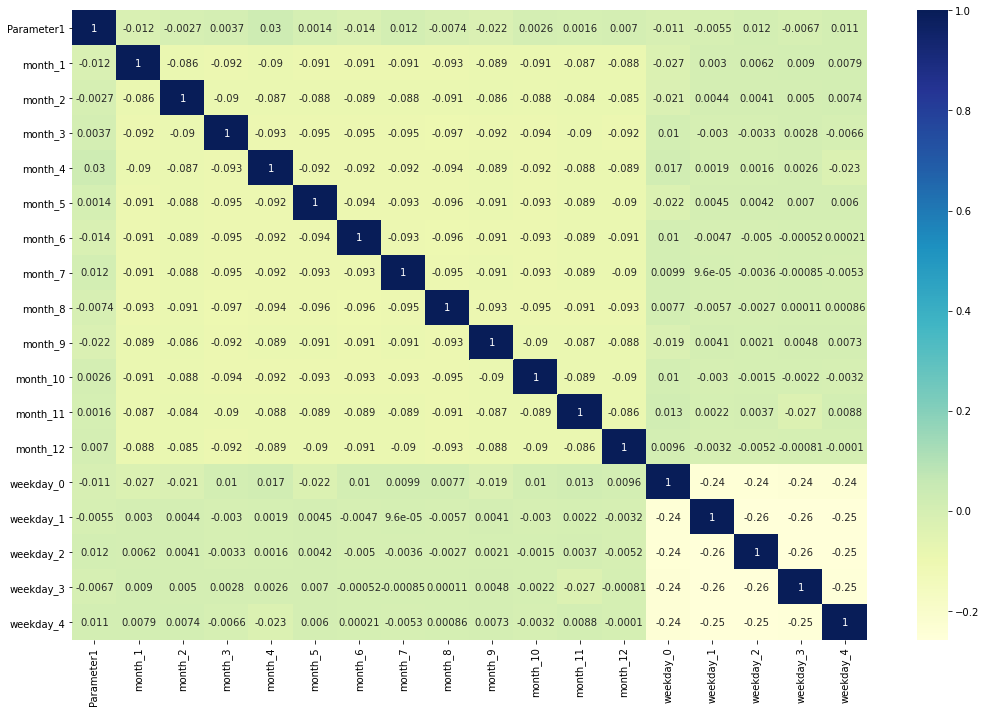

In [414]:
plt.figure(figsize = (15, 10))
sns.heatmap(X.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [415]:
# Putting response variable to y
y = daily_df1['profit']

In [416]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train.shape, X_test.shape

((3653, 18), (1566, 18))

In [417]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 80 candidates, totalling 320 fits
CPU times: user 303 ms, sys: 56 ms, total: 359 ms
Wall time: 455 ms


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [2, 3, 4, 5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [418]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.003985      0.000039         0.001863        0.000044   
1       0.004129      0.000095         0.001862        0.000034   
2       0.004330      0.000369         0.002062        0.000105   
3       0.004383      0.000266         0.002031        0.000101   
4       0.004274      0.000133         0.002065        0.000275   

  param_criterion param_max_depth param_min_samples_leaf  \
0            gini               2                      2   
1            gini               2                      3   
2            gini               2                      4   
3            gini               2                      5   
4            gini               2                     10   

                                              params  split0_test_score  \
0  {'criterion': 'gini', 'max_depth': 2, 'min_sam...           0.743982   
1  {'criterion': 'gini', 'max_depth': 2, 'min_sam...           0.743982   
2  {'criterion': 'gini', 'max_depth': 2, 'min_sam...           0.743982   
3  {'criterion': 'gini', 'max_depth': 2, 'min_sam...           0.743982   
4  {'criterion': 'gini', 'max_depth': 2, 'min_sam...           0.742888   

   split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
0           0.742607           0.741512           0.744797         0.743225   
1           0.742607           0.741512           0.744797         0.743225   
2           0.742607           0.741512           0.744797         0.743225   
3           0.742607           0.741512           0.744797         0.743225   
4           0.742607           0.741512           0.744797         0.742951   

   std_test_score  rank_test_score  
0        0.001261                4  
1        0.001261                4  
2        0.001261                4  
3        0.001261                4  
4        0.001184               29

In [419]:
score_df.nlargest(5,"mean_test_score")

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
12       0.006347      0.001341         0.002366        0.000537   
52       0.006091      0.000707         0.002733        0.000432   
51       0.006223      0.000236         0.002760        0.000101   
0        0.003985      0.000039         0.001863        0.000044   
1        0.004129      0.000095         0.001862        0.000034   

   param_criterion param_max_depth param_min_samples_leaf  \
12            gini               3                     10   
52         entropy               3                     10   
51         entropy               3                      5   
0             gini               2                      2   
1             gini               2                      3   

                                               params  split0_test_score  \
12  {'criterion': 'gini', 'max_depth': 3, 'min_sam...           0.748359   
52  {'criterion': 'entropy', 'max_depth': 3, 'min_...           0.748359   
51  {'criterion': 'entropy', 'max_depth': 3, 'min_...           0.743982   
0   {'criterion': 'gini', 'max_depth': 2, 'min_sam...           0.743982   
1   {'criterion': 'gini', 'max_depth': 2, 'min_sam...           0.743982   

    split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
12           0.742607           0.741512           0.744797         0.744319   
52           0.742607           0.741512           0.744797         0.744319   
51           0.742607           0.742607           0.744797         0.743498   
0            0.742607           0.741512           0.744797         0.743225   
1            0.742607           0.741512           0.744797         0.743225   

    std_test_score  rank_test_score  
12        0.002615                1  
52        0.002615                1  
51        0.000937                3  
0         0.001261                4  
1         0.001261                4

In [420]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, random_state=42)

In [421]:
grid_search.best_score_

0.7443186311987556

In [422]:
dt_best = grid_search.best_estimator_
evaluate_model(dt_best)

Train Accuracy : 0.7445934848070079
Train Confusion Matrix:
[[2707    7]
 [ 926   13]]
--------------------------------------------------
Test Accuracy : 0.7318007662835249
Test Confusion Matrix:
[[1141    3]
 [ 417    5]]


In [423]:
from sklearn.metrics import classification_report
print(classification_report(y_test, dt_best.predict(X_test)))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84      1144
           1       0.62      0.01      0.02       422

    accuracy                           0.73      1566
   macro avg       0.68      0.50      0.43      1566
weighted avg       0.70      0.73      0.62      1566



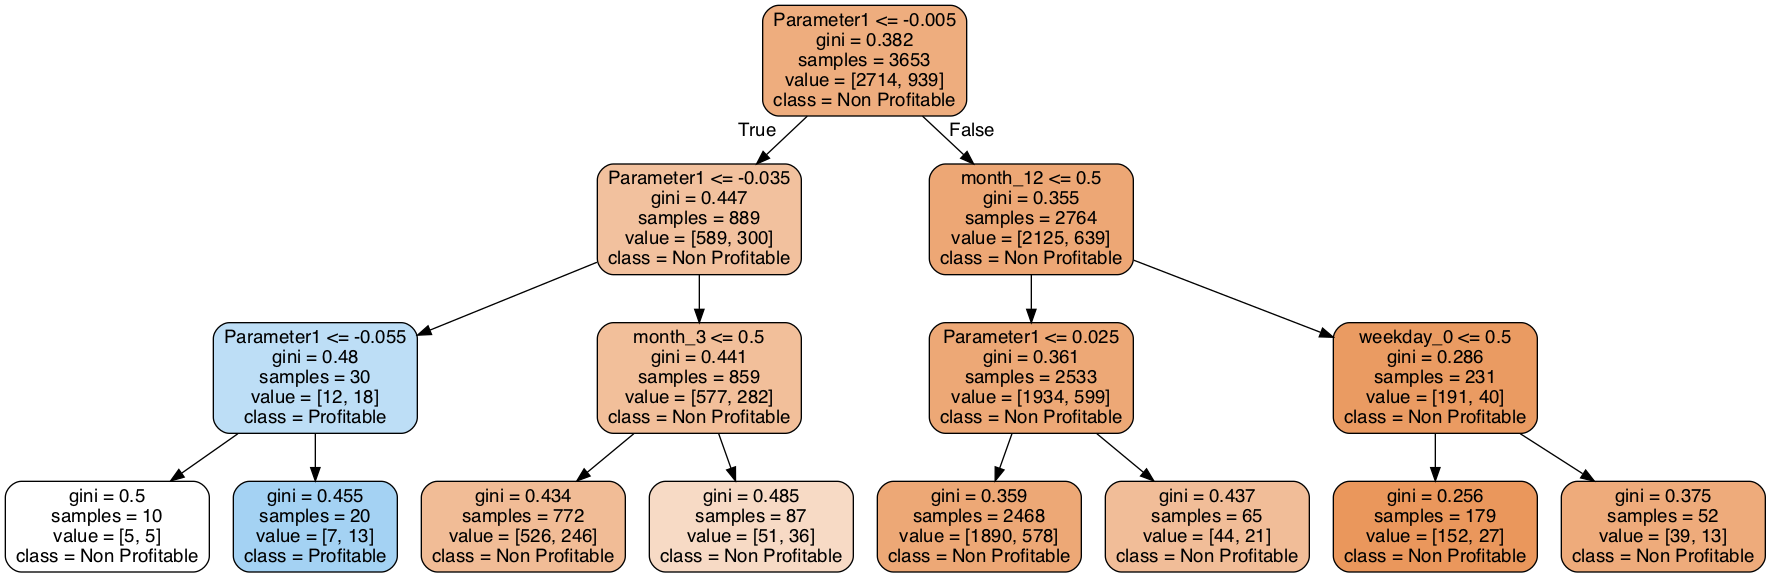

In [424]:
gph = get_dt_graph(dt_best)
Image(gph.create_png())